In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot


import warnings
warnings.filterwarnings('ignore')

# Abstract

En el mundo del fútbol es bien sabido que los jugadores mejor valuados suelen ser aquellos con mejores y más grandes logros individuales, mayor número de goles, mayor cantidad de pases completados, mejor tasa de intercepciones, etcétera, sin embargo, una pregunta que nos queda hacernos bajo este escenario, es si estas métricas individuales están correlacionadas con sus habilidades físicas, y si esto afecta, por ende, su valor en el mercado.

Aunque subjetivamente, entrenadores, comentaristas y los mismos aficionados tendemos a medir las capacidades físicas de los jugadores basándonos en nuestro criterio, esto no suele tener una repercusión mayor y pocos son los analistas que buscan medir y comparar estos atributos de manera cuantitava en una escala real. Una de las mejores fuentes para poder analizar con números las capacidades físicas y futbolísticas de los jugadores suelen ser los juegos de video que simulan la realidad mediante su programación; en estos podemos ver no solo una réplica de la imagen física de los jugadores, si no que también le añaden sus características de juego mediante la cuantificación de sus habilidades, dándonos como resultado una réplica virtual lo más parecida posible al jugador.

Con estos datos buscaremos realizar este análisis en el cual mediante modelos econométricos veremos si las cualidades físicas pesan igual que las métricas individuales en el valor individual de cada jugador.

## Objetivo

Comprobar si las capacidades físicas y habilidades de juego individuales de cada individuo influyen de manera directa o indirecta en el valor de mercado de un jugador.

## Hipótesis

- La habilidad general de cada jugador estará correlacionada con el valor de cada jugador
- Las habilidades particulares estarán correlacionadas positivamente con la habiliadad general, por consecuencia estarán relacioandas con el valor de cada jugador
- Los mercados más competitivos serán los mercados Europeos y latinoamericanos, y ahí podremos encontrar las mejores muestras de los puntos anteriores
- Dependiendo de la posición, las habiliadades particulares que influyan en el valor de cada jugador tenderán a cambiar




## Data sets y Variables

- ‘Players Stats.csv’ – Data set central, en donde encontramos toda la información sobre cada jugador (Obtenido del juego Pro Evolution Soccer 2020)
- ‘iso_countries2.csv’ – Contiene los nombres de los países, junto con su abreviación ISO-3 y el continente al que pertenecen, el cual se utilizó para agregar la variable ‘Continente’ al data set central. 
- ‘geo_spa_eng.csv’ – Contiene los nombres de los países en ingles y español, el cual se utilizó para agregar la variable ‘Country_ENG’ al dataset original.
- ‘positions.csv’ – Contiene las posiciones de ‘Defender’, ‘Midfield’ y ‘Forwards’  agregadas según las abreviaciones del data set original, para agregar la variable ‘Pos’ al data set original.


## Variables centrales numéricas utilizadas del Data set final.
- Valor: Valuación del jugador en USD
- Age: Edad del jugador
- Height: Altura del jugador en centímetros
- Current Ability: Valor numérico que muestra la habilidad actual del jugador. Numérica.

## Variables centrales categóricas utilizadas del Data set final.
- Nation: País donde nació el jugador
- Country_Based: País en donde el jugador juega actualmente
- Continent_Based: Continente en donde el jugador juega actualmente
- Preferred Foot: El pie hábil del jugador
- Pos: Posición en la que juega el jugador.
- Division: División en la cual juega el jugador actualmente


# Limpieza de datos

El proceso de limpieza de datos se divide en dos partes, una parte de homogenización y una segunda de toma de valores útiles.

La primer parte consiste principalmente en una homogenización de variables categóricas, necesitabamos incluir el continente donde el jugador recidía al momento del levantamiento de muestra para hacer las comparaciones por locación, sin embargo los códigos de país estaban estructurados de maneras no comparables con la base de datos que teníamos de continente, por lo cual se hicieron varias adecuaciones con los nombres de las naciones (de nacimiento de residencia), para poder incluir al final el dato del continente.

En esta sección también se incluyó un agrupamiento de las posiciones preferidas, ya que estaban desglozadas en más de 10 posiciones diferentes, las agrupados en solo 4, portero, defensor, medio y atacante, esto para poder hacer el trabajo más concreto y bajo el supuesto de que las características dentro de este agrupamiento no cambiarán lo suficiente como para ser relevantes.

Por último redujimos la base de datos solo a los valores que nos interesaban. Dado que que la base de datos tenía información de múltiples ligas de todo el mundo, la mayoría de estas no nos servían pues presentaban prácticamente valores fuera de cero sobre el valor de los jugadores, por ello es que decidimos tomar solo la primer liga o liga A de cada país, y dejar fuera también cualquier liga que no tuviera datos de valor de jugador (liga con valor agregado de cero).

En una siguiente etapa, eliminamos de la base de datos todo lo que tuviera que ver con porteros, pues sus variables eran diferentes a las de los jugadores de campo, y esto significaba el ruido de un agente no comparable en el modelo (esta limpieza se hizo en la parte de regresión).

Una ventaja que tuvimos con esta base de datos es que no presenta valores nulos, pues se trata de una base de un videojuego y tiene información completa de cada individuo, o en su defecto, un valor cero o "desconodido" (como cuando el jugador no tenía un equipo de momento), por lo que no tuvimos que hacer manejo de valores nulos.

In [2]:
# Datasets que vamos a estar utilizando

df = pd.read_csv('Players Stats.csv')
iso = pd.read_csv('iso_countries2.csv', encoding='latin-1')
geo_lang = pd.read_csv('geo_spa_eng.csv')
pos = pd.read_csv('positions.csv', encoding = "latin-1")



In [3]:
#Renombramos y reemplazamos valores de columnas
iso.rename({'ISO 3': 'Nation', 'Nombre':'Pais'}, axis=1, inplace=True)
iso.replace({'Reino Unido':'Inglaterra'},inplace=True)

geo_lang.rename({'Spanish':'Pais', 'English':'Country_ENG'}, axis=1, inplace=True)
geo_lang.replace({'United Kingdom':'England', 'Reino': 'Inglaterra'},inplace=True)

geo_lang[geo_lang['Pais']=='Inglaterra']

Country_ENG        Pais
39     England  Inglaterra

In [4]:
geo_lang

Country_ENG         Pais
0            Albania      Albania
1            Austria      Austria
2            Belarus  Bielorrusia
3            Belgium      Bélgica
4           Bulgaria     Bulgaria
..               ...          ...
99             Yemen        Yemen
100        Australia    Australia
101         Kiribati     Kiribati
102  Solomon Islands    Islander 
103          Vanuatu            0

[104 rows x 2 columns]

In [5]:
# Renombranos paises de Europa y LATAM que no coinciden en el ISO entre ambos DataFrames

df['Nation'].replace({'GER': 'DEU', 'BUL': 'BGR', 'CRO': 'HRV', 'DEN': 'DNK', 'GRE': 'GRC', 'MON': 'MCO', 'NED': 'NLD', 'POR': 'PRT', 'ENG': 'GBR', 'SUI': 'CHE', 'CHI': 'CHL', 'CRC': 'CRI', 'GRN': 'GRD', 'GUA': 'GTM', 'HAI': 'HTI', 'HON': 'HND', 'NCA': 'NIC', 'PAR': 'PRY', 'PUR': 'PRI', 'URU': 'URY'},
                        inplace=True)

In [7]:
df.drop({'Unnamed: 0'}, axis=1, inplace=True)

In [8]:
# Agregamos el continente a cada país de origen

df2 = pd.merge(df, iso, on='Nation', how='left')
df2.head()

Name      Position     Club                  Division  \
0    Michael Essien     DM, M (C)  SÃ¤bail      Azeri Premier League   
1            Maicon      D/WB (R)  Unknown  Hong Kong Premier League   
2       Yaya TourÃ©  DM, M/AM (C)  Unknown   French Reserves Group 3   
3    Yoann Gourcuff      M/AM (C)  Unknown                   Unknown   
4  Daniel Sturridge        ST (C)  Unknown                   Unknown   

                                   Based Nation  Height  Weight  Age  \
0            Azerbaijan (Premier League)    GHA     178      84   36   
1  Hong Kong (China PR) (Premier League)    BRA     186      82   37   
2              France (Reserves Group 3)    CIV     188      90   36   
3                                 France    FRA     185      82   32   
4                                England    GBR     183      79   29   

  Preferred Foot  ... Bravery (Injury Situations) Balance  Anticipation  \
0          Right  ...                          16      13            15   
1          Right  ...                           7       7             6   
2          Right  ...                          12      15            15   
3          Right  ...                           7      12            14   
4           Left  ...                           9      14            15   

   Agility  Aggression  Aerial Reach  Acceleration  Continente  \
0        7          14             1             7          AF   
1       14           8             5            12         LAM   
2        7          11             4             7          AF   
3       13           6             2            10          EU   
4       13           9             3            12          EU   

              Pais  Vehículo  
0            Ghana        GH  
1           Brasil        BR  
2  Costa de Marfil        CI  
3          Francia         F  
4       Inglaterra        GB  

[5 rows x 66 columns]

In [10]:
# Agregamos columna con los paises en ingles (Para poder hacer un match con respecto al pais en donde juegan)
df3 = pd.merge(df2, geo_lang, on='Pais', how='left')
df3

Name                Position       Club  \
0          Michael Essien               DM, M (C)    SÃ¤bail   
1                  Maicon                D/WB (R)    Unknown   
2             Yaya TourÃ©            DM, M/AM (C)    Unknown   
3          Yoann Gourcuff                M/AM (C)    Unknown   
4        Daniel Sturridge                  ST (C)    Unknown   
...                   ...                     ...        ...   
144745  Antoine Griezmann        AM (RLC), ST (C)  Barcelona   
144746              Oscar          M (C), AM (RC)       SIPG   
144747             Neymar  M (L), AM (LC), ST (C)   Paris SG   
144748  Cristiano Ronaldo         AM (RL), ST (C)   Juventus   
144749       Lionel Messi         AM (RC), ST (C)  Barcelona   

                        Division                                  Based  \
0           Azeri Premier League            Azerbaijan (Premier League)   
1       Hong Kong Premier League  Hong Kong (China PR) (Premier League)   
2        French Reserves Group 3              France (Reserves Group 3)   
3                        Unknown                                 France   
4                        Unknown                                England   
...                          ...                                    ...   
144745    Spanish First Division                 Spain (First Division)   
144746      Chinese Super League                   China (Super League)   
144747         Ligue 1 Conforama             France (Ligue 1 Conforama)   
144748           Italian Serie A                        Italy (Serie A)   
144749    Spanish First Division                 Spain (First Division)   

       Nation  Height  Weight  Age Preferred Foot  ... Balance Anticipation  \
0         GHA     178      84   36          Right  ...      13           15   
1         BRA     186      82   37          Right  ...       7            6   
2         CIV     188      90   36          Right  ...      15           15   
3         FRA     185      82   32          Right  ...      12           14   
4         GBR     183      79   29           Left  ...      14           15   
...       ...     ...     ...  ...            ...  ...     ...          ...   
144745    FRA     175      71   28           Left  ...      15           15   
144746    BRA     181      71   27          Right  ...       9           14   
144747    BRA     175      68   27          Right  ...      14           16   
144748    PRT     185      83   34         Either  ...      14           18   
144749    ARG     170      72   32           Left  ...      19           19   

        Agility  Aggression  Aerial Reach  Acceleration  Continente  \
0             7          14             1             7          AF   
1            14           8             5            12         LAM   
2             7          11             4             7          AF   
3            13           6             2            10          EU   
4            13           9             3            12          EU   
...         ...         ...           ...           ...         ...   
144745       15          13             2            15          EU   
144746       15          12             2            13         LAM   
144747       18          10             4            17         LAM   
144748       13           6             2            15          EU   
144749       19           7             2            18         LAM   

                   Pais  Vehículo  Country_ENG  
0                 Ghana        GH          NaN  
1                Brasil        BR       Brazil  
2       Costa de Marfil        CI          NaN  
3               Francia         F       France  
4            Inglaterra        GB      England  
...                 ...       ...          ...  
144745          Francia         F       France  
144746           Brasil        BR       Brazil  
144747           Brasil        BR       Brazil  
144748         Portugal         P     Portugal  
144749    

In [11]:
# Buscamos valores nulos
pd.set_option('display.max_row', 68)

df3.isnull().sum()

Name                                        0
Position                                    0
Club                                        0
Division                                    0
Based                                       0
Nation                                      0
Height                                      0
Weight                                      0
Age                                         0
Preferred Foot                              0
Best Pos                                    0
Best Role                                   0
Value                                       0
Wage (Weekly)                               0
Current Ability                             0
Potential Ability                           0
Work Rate                                   0
Oportunity Vision                           0
Throwing (Goalkeeper)                       0
Technique                                   0
Teamwork                                    0
Tackling                          

In [12]:
# Corroboramos que los paises que tienen null en la columna de Country_ENG no corresponden ni a LAM ni a EU
test = df3.groupby(['Nation'], as_index=False).count()

test[test.Pais==0].head(5)

Nation  Name  Position  Club  Division  Based  Height  Weight  Age  \
3     ALG   183       183   183       183    183     183     183  183   
5     ANG   102       102   102       102    102     102     102  102   
8     ARU     2         2     2         2      2       2       2    2   
9     ASA    53        53    53        53     53      53      53   53   
17    BER   141       141   141       141    141     141     141  141   

    Preferred Foot  ...  Balance  Anticipation  Agility  Aggression  \
3              183  ...      183           183      183         183   
5              102  ...      102           102      102         102   
8                2  ...        2             2        2           2   
9               53  ...       53            53       53          53   
17             141  ...      141           141      141         141   

    Aerial Reach  Acceleration  Continente  Pais  Vehículo  Country_ENG  
3            183           183           0     0         0            0  
5            102           102           0     0         0            0  
8              2             2           0     0         0            0  
9             53            53           0     0         0            0  
17           141           141           0     0         0            0  

[5 rows x 67 columns]

In [13]:
df3.head(2)

Name   Position     Club                  Division  \
0  Michael Essien  DM, M (C)  SÃ¤bail      Azeri Premier League   
1          Maicon   D/WB (R)  Unknown  Hong Kong Premier League   

                                   Based Nation  Height  Weight  Age  \
0            Azerbaijan (Premier League)    GHA     178      84   36   
1  Hong Kong (China PR) (Premier League)    BRA     186      82   37   

  Preferred Foot  ... Balance Anticipation  Agility  Aggression  Aerial Reach  \
0          Right  ...      13           15        7          14             1   
1          Right  ...       7            6       14           8             5   

   Acceleration  Continente    Pais  Vehículo  Country_ENG  
0             7          AF   Ghana        GH          NaN  
1            12         LAM  Brasil        BR       Brazil  

[2 rows x 67 columns]

In [14]:
# Agregamos columna que incluya el pais donde el jugador esta jugando actualmente
df3[['Country_Based', '33', '44']] = df3['Based'].str.split(pat='(', expand=True)
df3.drop(['33','44'], axis=1, inplace=True)
df3['Country_Based'] = df3['Country_Based'].str.rstrip()

df3.head()

Name      Position     Club                  Division  \
0    Michael Essien     DM, M (C)  SÃ¤bail      Azeri Premier League   
1            Maicon      D/WB (R)  Unknown  Hong Kong Premier League   
2       Yaya TourÃ©  DM, M/AM (C)  Unknown   French Reserves Group 3   
3    Yoann Gourcuff      M/AM (C)  Unknown                   Unknown   
4  Daniel Sturridge        ST (C)  Unknown                   Unknown   

                                   Based Nation  Height  Weight  Age  \
0            Azerbaijan (Premier League)    GHA     178      84   36   
1  Hong Kong (China PR) (Premier League)    BRA     186      82   37   
2              France (Reserves Group 3)    CIV     188      90   36   
3                                 France    FRA     185      82   32   
4                                England    GBR     183      79   29   

  Preferred Foot  ... Anticipation Agility  Aggression  Aerial Reach  \
0          Right  ...           15       7          14             1   
1          Right  ...            6      14           8             5   
2          Right  ...           15       7          11             4   
3          Right  ...           14      13           6             2   
4           Left  ...           15      13           9             3   

   Acceleration  Continente             Pais  Vehículo  Country_ENG  \
0             7          AF            Ghana        GH          NaN   
1            12         LAM           Brasil        BR       Brazil   
2             7          AF  Costa de Marfil        CI          NaN   
3            10          EU          Francia         F       France   
4            12          EU       Inglaterra        GB      England   

   Country_Based  
0     Azerbaijan  
1      Hong Kong  
2         France  
3         France  
4        England  

[5 rows x 68 columns]

In [15]:
# Agregamos el continente del pais donde juegan
geo_lang.rename({'Country_ENG':'Country_Based'}, axis=1, inplace=True)

df4 = pd.merge(df3, geo_lang, how='left', on='Country_Based')
df4.head(5)

Name      Position     Club                  Division  \
0    Michael Essien     DM, M (C)  SÃ¤bail      Azeri Premier League   
1            Maicon      D/WB (R)  Unknown  Hong Kong Premier League   
2       Yaya TourÃ©  DM, M/AM (C)  Unknown   French Reserves Group 3   
3    Yoann Gourcuff      M/AM (C)  Unknown                   Unknown   
4  Daniel Sturridge        ST (C)  Unknown                   Unknown   

                                   Based Nation  Height  Weight  Age  \
0            Azerbaijan (Premier League)    GHA     178      84   36   
1  Hong Kong (China PR) (Premier League)    BRA     186      82   37   
2              France (Reserves Group 3)    CIV     188      90   36   
3                                 France    FRA     185      82   32   
4                                England    GBR     183      79   29   

  Preferred Foot  ... Agility Aggression  Aerial Reach  Acceleration  \
0          Right  ...       7         14             1             7   
1          Right  ...      14          8             5            12   
2          Right  ...       7         11             4             7   
3          Right  ...      13          6             2            10   
4           Left  ...      13          9             3            12   

   Continente           Pais_x  Vehículo  Country_ENG  Country_Based  \
0          AF            Ghana        GH          NaN     Azerbaijan   
1         LAM           Brasil        BR       Brazil      Hong Kong   
2          AF  Costa de Marfil        CI          NaN         France   
3          EU          Francia         F       France         France   
4          EU       Inglaterra        GB      England        England   

       Pais_y  
0         NaN  
1         NaN  
2     Francia  
3     Francia  
4  Inglaterra  

[5 rows x 69 columns]

In [16]:
iso.rename({'Pais':'Pais_y'}, axis=1, inplace=True)
df5 = pd.merge(df4, iso, how='left', on='Pais_y')

df5.head(5)


Name      Position     Club                  Division  \
0    Michael Essien     DM, M (C)  SÃ¤bail      Azeri Premier League   
1            Maicon      D/WB (R)  Unknown  Hong Kong Premier League   
2       Yaya TourÃ©  DM, M/AM (C)  Unknown   French Reserves Group 3   
3    Yoann Gourcuff      M/AM (C)  Unknown                   Unknown   
4  Daniel Sturridge        ST (C)  Unknown                   Unknown   

                                   Based Nation_x  Height  Weight  Age  \
0            Azerbaijan (Premier League)      GHA     178      84   36   
1  Hong Kong (China PR) (Premier League)      BRA     186      82   37   
2              France (Reserves Group 3)      CIV     188      90   36   
3                                 France      FRA     185      82   32   
4                                England      GBR     183      79   29   

  Preferred Foot  ... Acceleration Continente_x           Pais_x  Vehículo_x  \
0          Right  ...            7           AF            Ghana          GH   
1          Right  ...           12          LAM           Brasil          BR   
2          Right  ...            7           AF  Costa de Marfil          CI   
3          Right  ...           10           EU          Francia           F   
4           Left  ...           12           EU       Inglaterra          GB   

   Country_ENG  Country_Based      Pais_y  Continente_y  Nation_y  Vehículo_y  
0          NaN     Azerbaijan         NaN           NaN       NaN         NaN  
1       Brazil      Hong Kong         NaN           NaN       NaN         NaN  
2          NaN         France     Francia            EU       FRA           F  
3       France         France     Francia            EU       FRA           F  
4      England        England  Inglaterra            EU       GBR          GB  

[5 rows x 72 columns]

In [17]:
df5.rename({'Continente_y': 'Continent_Based', 'Continente_x':'Continente'}, axis=1, inplace=True)

In [18]:
df5.head(5)

Name      Position     Club                  Division  \
0    Michael Essien     DM, M (C)  SÃ¤bail      Azeri Premier League   
1            Maicon      D/WB (R)  Unknown  Hong Kong Premier League   
2       Yaya TourÃ©  DM, M/AM (C)  Unknown   French Reserves Group 3   
3    Yoann Gourcuff      M/AM (C)  Unknown                   Unknown   
4  Daniel Sturridge        ST (C)  Unknown                   Unknown   

                                   Based Nation_x  Height  Weight  Age  \
0            Azerbaijan (Premier League)      GHA     178      84   36   
1  Hong Kong (China PR) (Premier League)      BRA     186      82   37   
2              France (Reserves Group 3)      CIV     188      90   36   
3                                 France      FRA     185      82   32   
4                                England      GBR     183      79   29   

  Preferred Foot  ... Acceleration Continente           Pais_x  Vehículo_x  \
0          Right  ...            7         AF            Ghana          GH   
1          Right  ...           12        LAM           Brasil          BR   
2          Right  ...            7         AF  Costa de Marfil          CI   
3          Right  ...           10         EU          Francia           F   
4           Left  ...           12         EU       Inglaterra          GB   

   Country_ENG  Country_Based      Pais_y  Continent_Based  Nation_y  \
0          NaN     Azerbaijan         NaN              NaN       NaN   
1       Brazil      Hong Kong         NaN              NaN       NaN   
2          NaN         France     Francia               EU       FRA   
3       France         France     Francia               EU       FRA   
4      England        England  Inglaterra               EU       GBR   

   Vehículo_y  
0         NaN  
1         NaN  
2           F  
3           F  
4          GB  

[5 rows x 72 columns]

In [20]:
# Agregamos agrupación de posiciones
df5 = pd.merge(df5, pos, how='inner',on='Best Pos')

df5

Name             Position         Club  \
0         Michael Essien            DM, M (C)      SÃ¤bail   
1        Mohamed Sissoko            DM, M (C)      Unknown   
2           Gareth Barry            DM, M (C)      Unknown   
3              DenÃ­lson            DM, M (C)      Unknown   
4                Jucilei            DM, M (C)      Unknown   
...                  ...                  ...          ...   
144745  MÃ¡rio Fernandes             D/WB (R)  CSKA Moscow   
144746  Daniel Caligiuri  D/WB (R), M/AM (RL)  FC Augsburg   
144747     Daryl Janmaat             D/WB (R)      Watford   
144748    Manuel Lazzari           D/WB/M (R)        Lazio   
144749     JoÃ£o Cancelo        D/WB/M/AM (R)     Man City   

                                 Division                           Based  \
0                    Azeri Premier League     Azerbaijan (Premier League)   
1                                 Unknown                          France   
2                                 Unknown                         England   
3       Brazilian National Lower Division         Brazil (Lower Division)   
4                                 Unknown                          Brazil   
...                                   ...                             ...   
144745             Russian Premier League         Russia (Premier League)   
144746                         Bundesliga            Germany (Bundesliga)   
144747               Sky Bet Championship  England (Sky Bet Championship)   
144748                    Italian Serie A                 Italy (Serie A)   
144749           English Premier Division      England (Premier Division)   

       Nation_x  Height  Weight  Age Preferred Foot  ... Continente  \
0           GHA     178      84   36          Right  ...         AF   
1           MLI     191      85   34          Right  ...         AF   
2           GBR     183      78   38           Left  ...         EU   
3           BRA     178      73   31          Right  ...        LAM   
4           BRA     185      82   31          Right  ...        LAM   
...         ...     ...     ...  ...            ...  ...        ...   
144745      RUS     187      80   28          Right  ...         EU   
144746      DEU     182      79   30          Right  ...         EU   
144747      NLD     185      80   29          Right  ...         EU   
144748      ITA     174      65   25     Right Only  ...         EU   
144749      PRT     182      74   25          Right  ...         EU   

                 Pais_x  Vehículo_x  Country_ENG  Country_Based      Pais_y  \
0                 Ghana          GH          NaN     Azerbaijan         NaN   
1                  Malí         RMM          NaN         France     Francia   
2            Inglaterra          GB      England        England  Inglaterra   
3                Brasil          BR       Brazil         Brazil      Brasil   
4                Brasil          BR       Brazil         Brazil      Brasil   
...                 ...         ...          ...            ...         ...   
144745  Federacion Rusa         RUS          NaN         Russia       Rusia   
144746         Alemania           D      Germany        Germany    Alemania   
144747     Países Bajos          NL          NaN        England  Inglaterra   
144748           Italia           I        Italy          Italy      Italia   
144749         Portugal           P     Portugal        England  Inglaterra   

        Continent_Based  Nation_y  Vehículo_y       Pos  
0                   NaN       NaN         NaN  Midfield  
1                    EU       FRA           F  Midfield  
2                    EU       GBR          GB  Midfield  
3                   LAM       BRA          BR  Midfield  
4                   LAM       BRA          BR  Midfield  
...                 ...       ...         ...       ...  
144745              NaN       NaN         NaN  Defender  
144746               EU       DEU           D  Defender  
144747               EU   

In [250]:
#Nos quedamos solo con las primeras divisiones de cada país (las que tienen más valor)

divisions=df5[["Country_Based", 'Division','Value']].groupby(['Country_Based','Division']).mean().reset_index().sort_values(by='Value', ascending=False).round(2)


Cntry=list((df5["Country_Based"].unique()))
divisions2=pd.DataFrame(columns=["Country_Based", 'Division','Value'])

for country in Cntry:
    Temp0=divisions[divisions['Country_Based']==country]
    max=Temp0['Value'].max()
    Temp1=Temp0[Temp0['Value']==max]
    divisions2=pd.concat([divisions2,Temp1])

divisions2 = divisions2[divisions2['Value']>0]

div=list((divisions2['Division']))

df6=df5[df5['Division'].isin(div)]

df6['Continent_Based']=df6['Continent_Based'].fillna('Unknown')

In [251]:

a=df6.loc[df6['Continent_Based']=='Unknown', ['Club', 'Division']]

len(a['Division'].unique())

99

# EDA



El análisis exploratorio se hizo en dos partes, una primer parte de histogramas para analizar las habilidades particulares, y donde se concentraban sus datos, y una segunda con análisis univariado y bivariado en el que vemos como las varaibles de valor y habilidad general interactuan con diferentes variables categóricas como continente, división o posición.

## Histogramas

En un primer acercamiento a las habilidades particulares podemos ver que por lo general, la mayoría tiende a una normal, es decir los jugadores en su máximo apogeo van a tender a la media en diferentes habilidades, sin embargo, podemos ver ciertas variables con movimientos particualres, como "Penalty Taking" que es un triangulo en descenso, lo que nos dice que son pocos los jugadores que son buenos cobrando penales, lo cual nos ayuda a pensar que si puede ser un determinante al momento de agregar valor al jugador.

Otra cosa que podemos observar en los histogramas es que las variables de Portero también tienen a inclinarse a una orilla, por lo cual optaremos por dejarlos como un grupo a analizar aparte y retirar esas variables para que no interfieran con el análisis en las regresiones

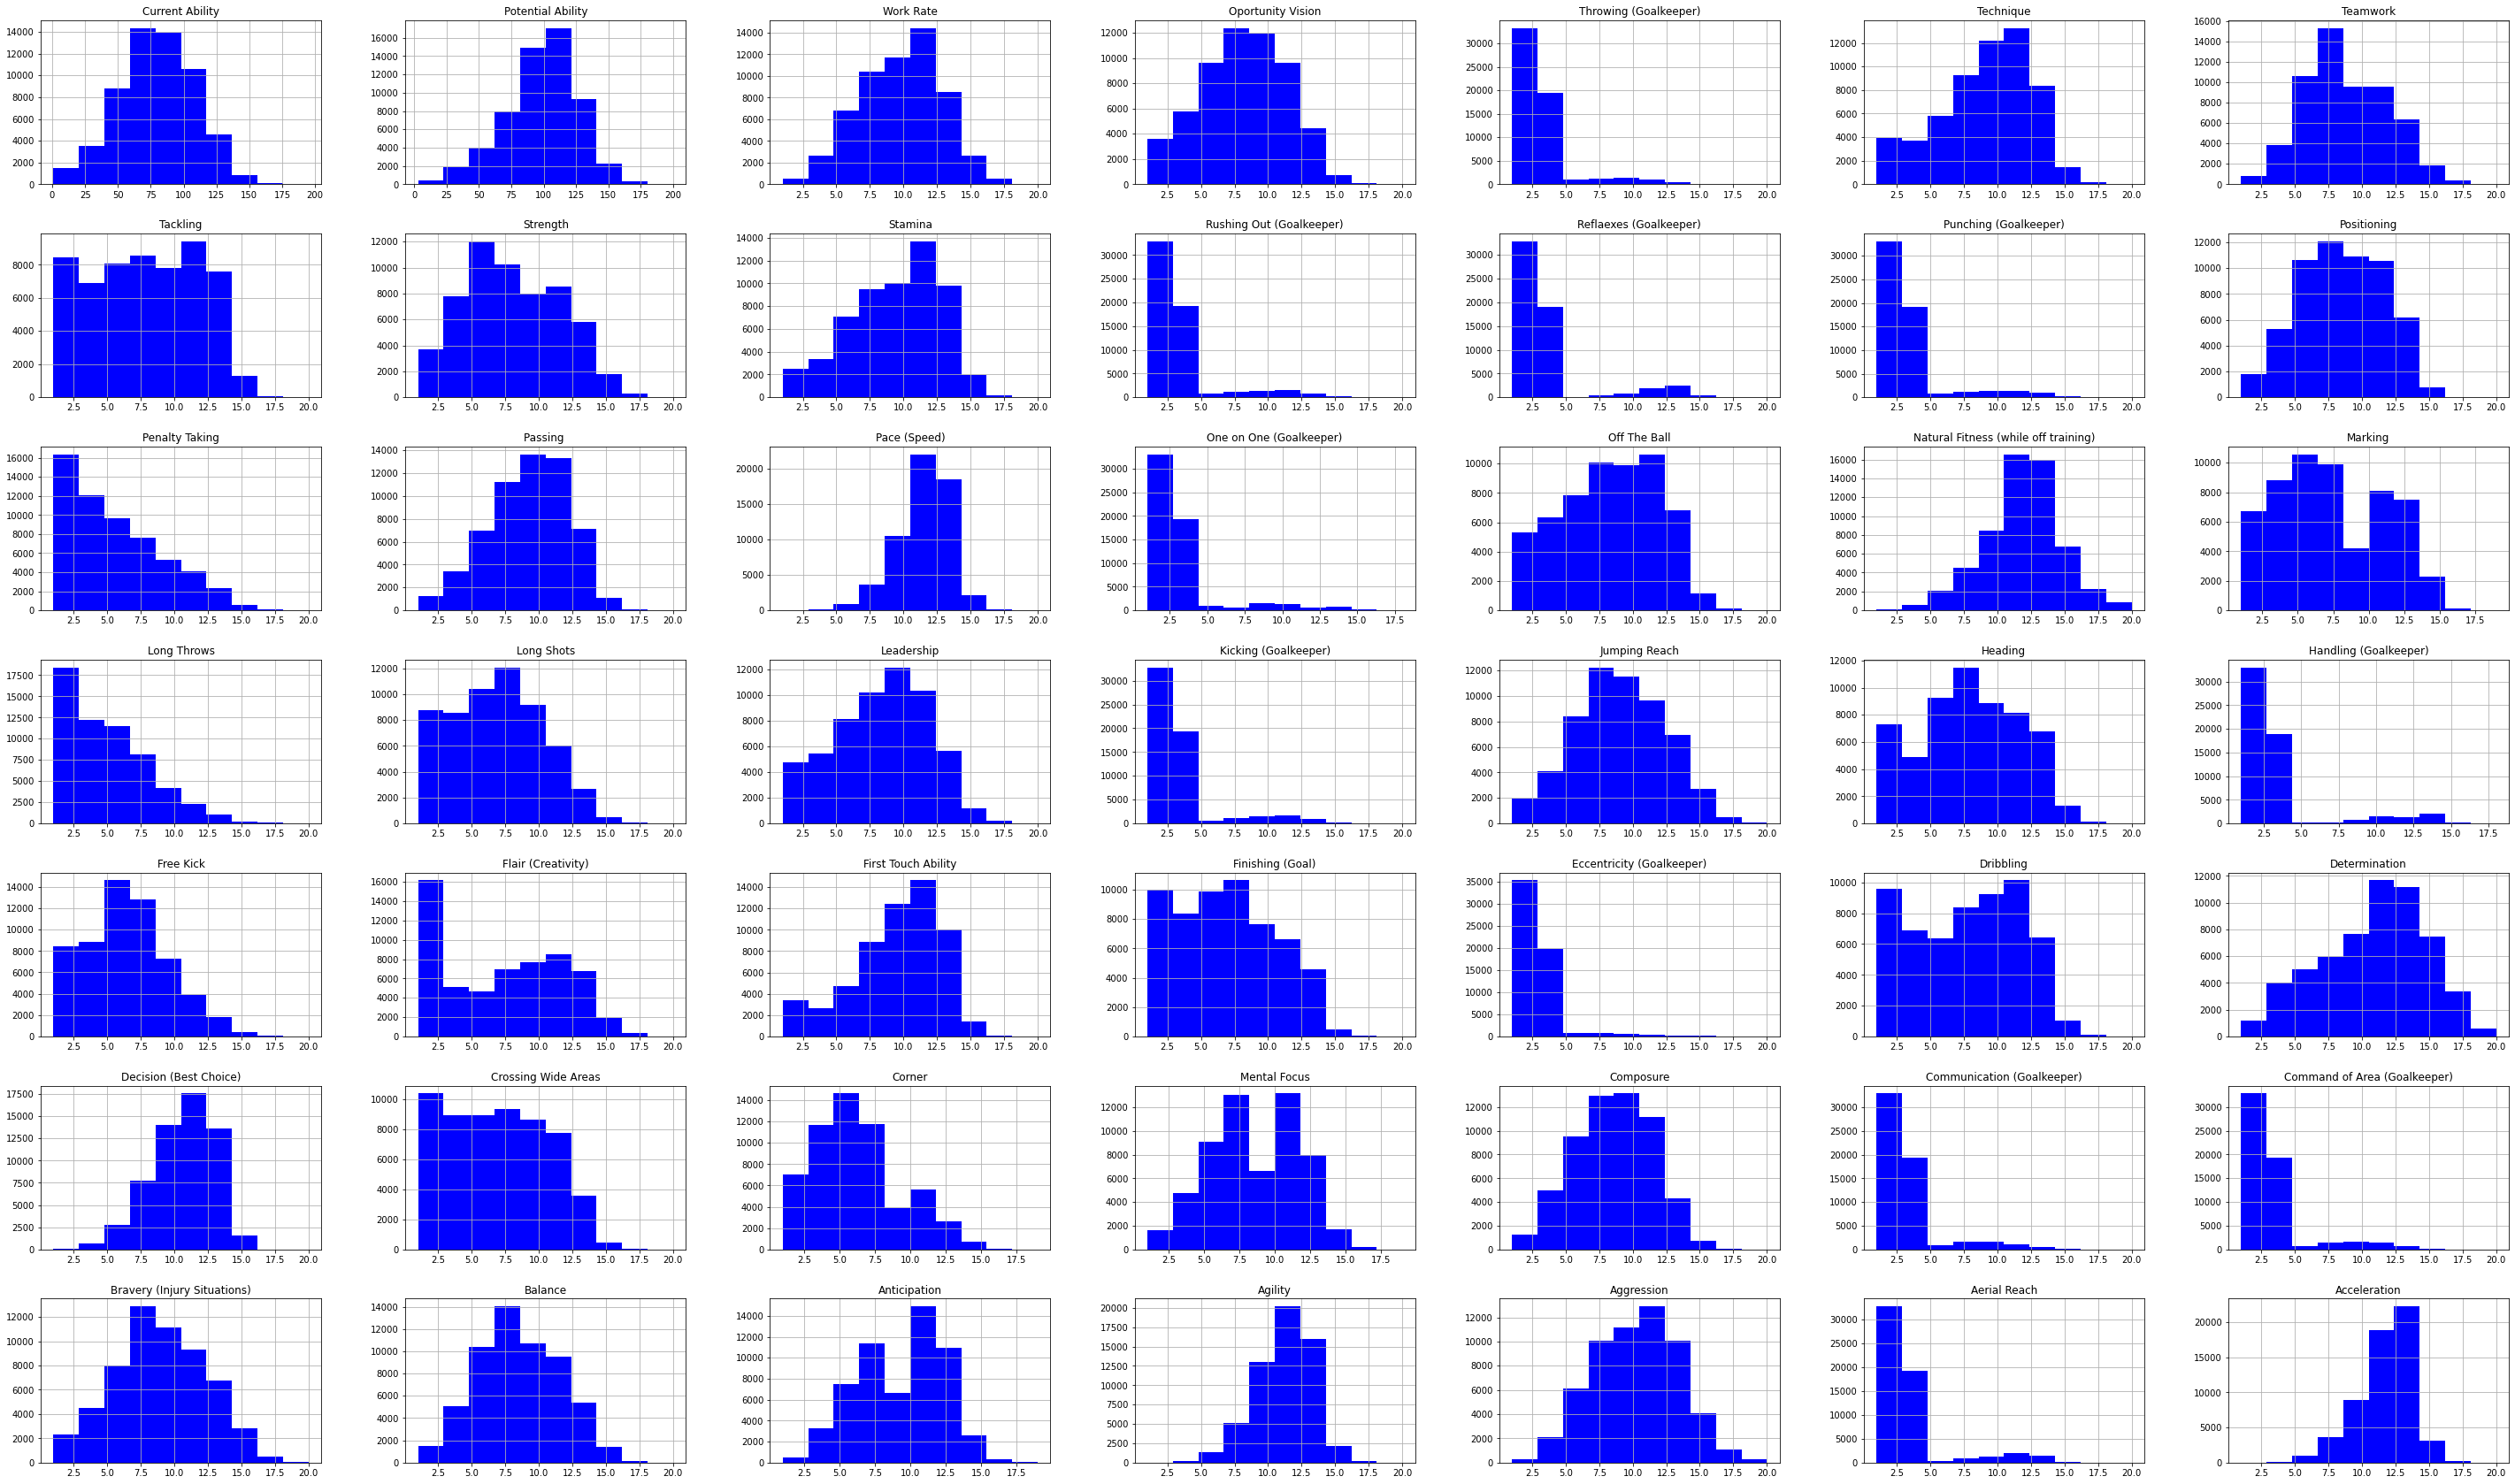

In [252]:
df_h = df6.loc[:, df6.columns != 'Value']
df_h.drop([ "Age",'Weight', 'Height','Wage (Weekly)'], axis = 1, inplace=True)
hist=df_h.hist(figsize=(50,30),color='blue')

In [236]:
df6.describe()

Height        Weight           Age         Value  Wage (Weekly)  \
count  58144.000000  58144.000000  58144.000000  5.814400e+04   5.814400e+04   
mean     180.196512     72.741418     23.651589  7.064232e+05   2.953825e+03   
std        7.189465      7.534613      5.528439  3.667748e+06   1.601675e+04   
min      150.000000     55.000000     14.000000  0.000000e+00   0.000000e+00   
25%      175.000000     68.000000     19.000000  0.000000e+00   0.000000e+00   
50%      180.000000     73.000000     23.000000  7.250000e+03   1.000000e+02   
75%      185.000000     78.000000     28.000000  1.200000e+05   7.750000e+02   
max      207.000000    110.000000     51.000000  9.100000e+07   1.200000e+06   

       Current Ability  Potential Ability     Work Rate  Oportunity Vision  \
count     58144.000000       58144.000000  58144.000000       58144.000000   
mean         79.277415          98.995614      9.779410           8.046110   
std          28.951528          27.961717      3.169234           3.363929   
min           1.000000           3.000000      1.000000           1.000000   
25%          60.000000          82.000000      7.000000           6.000000   
50%          80.000000         101.000000     10.000000           8.000000   
75%         100.000000         119.000000     12.000000          11.000000   
max         195.000000         200.000000     20.000000          20.000000   

       Throwing (Goalkeeper)  ...     Composure  Communication (Goalkeeper)  \
count           58144.000000  ...  58144.000000                58144.000000   
mean                2.752047  ...      8.478914                    2.819070   
std                 2.342551  ...      3.047949                    2.416721   
min                 1.000000  ...      1.000000                    1.000000   
25%                 1.000000  ...      6.000000                    1.000000   
50%                 2.000000  ...      9.000000                    2.000000   
75%                 3.000000  ...     11.000000                    3.000000   
max                20.000000  ...     20.000000                   20.000000   

       Command of Area (Goalkeeper)  Bravery (Injury Situations)  \
count                  58144.000000                 58144.000000   
mean                       2.884528                     8.884631   
std                        2.553134                     3.566084   
min                        1.000000                     1.000000   
25%                        1.000000                     6.000000   
50%                        2.000000                     9.000000   
75%                        3.000000                    12.000000   
max                       20.000000                    20.000000   

            Balance  Anticipation       Agility    Aggression  Aerial Reach  \
count  58144.000000  58144.000000  58144.000000  58144.000000  58144.000000   
mean       8.457571      9.204166     11.245030     10.238597      3.029702   
std        3.240508      2.920968      2.204607      3.340558      2.931085   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        6.000000      7.000000     10.000000      8.000000      1.000000   
50%        8.000000      9.000000     11.000000     10.000000      2.000000   
75%       11.000000     11.000000     13.000000     13.000000      3.000000   
max       20.000000     19.000000     20.000000     20.000000     20.000000   

       Acceleration  
count  58144.000000  
mean      11.826311  
std        2.152074  
min        1.000000  
25%       11.000000  
50%       12.000000  
75%       13.000000  
max       20.000000  

[8 rows x 54 columns]

## Análisis Univariado

El primer análisis univariado corresponde a 3 cortes que son división en la que se juega, país de nacimiento y posición preferida de los jugadores.

En cuanto a división es interesante ver que en el top 20 encontramos principalmente ligas latinoamericanas y europeas, con solo algunas divisiones de Asia o África, y dentro de estas divisiones encontramos más de la mitad de los datos, esto es impresionante consideranto que hablamos de casi 100 ligas que se están comparando, por lo cual podemos ver quienes son los continentes que definen como se mueve el mercado.

En cuanto a países de nacimiento, la tendencia es similar, por lo cual podemos intuir que el hecho de acaparar el mercado también influye en el desarrollo de nuevos jugadores, Europa no es solo consumidor, también busca generar jugadores.

Por último, soprende un poco que en cuanto a posiciones, la que más domine es la posición de defensa, seguida de la de tirador, no hay un comportamiento predecible entre las posiciones de campo y la cantidad de jugadores en ella.

In [23]:
#Agrupaciones para las figuras
div1=df6.groupby(['Division'])['Division'].agg(['count']).reset_index()
div1=div1[div1['Division']!='Unknown']

pais1=df6.groupby(['Pais_x'])['Pais_x'].agg(['count']).reset_index()

Bpos=df6.groupby(['Best Pos'])['Best Pos'].agg(['count']).reset_index()


In [24]:
#Gráficas de conteos
fig = make_subplots(rows=3, cols=1, subplot_titles=("Division","País de nacimiento", "Posición"))

fig.add_trace(go.Bar(x=div1['Division'],y=div1['count'],text=div1['count']), row=1, col=1)

fig.add_trace(go.Bar(x=pais1['Pais_x'],y=pais1['count'],text=pais1['count']),2,1)

fig.add_trace(go.Bar(x=Bpos['Best Pos'],y=Bpos['count'],text=Bpos['count']),3,1)

fig.update_traces(textangle=90,textfont_size=15,textposition='outside')
fig.update_layout(xaxis={'categoryorder':'total descending'},xaxis2={'categoryorder':'total descending'}, xaxis3={'categoryorder':'total descending'}, title_text='Cantidad de jugadores por')
fig.update_layout(
    autosize=False,
    width=2400,
    height=3000)
fig.show()

In [25]:
#Pie chart
foot=df6.groupby(['Preferred Foot'])['Preferred Foot'].agg(['count']).reset_index()

En cuanto a las características de los jugadores vemos que en cuestión de edad, la mayoría se concentran al rededor de los 19 años, y después comienza una caída abrupta de cantidad de jugadores por edad, pareciera que entre los 20 y 23 años comienzan a salirse jugadores, ya sea por falta de equipo o falta de talento, y posterior a esto, después de los 25 comienza una caída natural en las catidades, posiblemente debido a las salidas naturales o por lesiones.

En cuanto a altura, los datos también tienen a una normal, con ciertos picos cada tanto, por lo cual esta variable parece estar mal recolectada, por ello tenderemos a ignorarla.

La variable de habilidad general parece una normal cargada a su lado derecho, es decir, los jugadores, aunque repartidos de manera uniforme en cuestión de habilidad, tienden a buscar ser mejores, o los clubes tienden a buscar los mejores, por ello se agruparán algunas más en la segunda parte de la curva.

Por último, vemos que los jugadores diestro son más del 75%, con solo un 20% aprox. de jugadores zurdos, y el restante jugadores ambidiestros, es un dato interesante ver si estos grupos minoritarios tienden a ser parte de los jugadores con mayores habilidades.

In [254]:
#Histogramas
fig = make_subplots(rows=2, cols=2, subplot_titles=("Edad","Altura", "Habilidad","Pie preferido"), specs=[[{"type": "histogram"}, {"type": "histogram"}],[{"type": "histogram"}, {"type": "pie"}]])

fig.add_trace(go.Histogram(x=df6['Age'],showlegend=False), 1, 1)

fig.add_trace(go.Histogram(x=df6['Height'],showlegend=False), 2, 1)

fig.add_trace(go.Histogram(x=df6['Current Ability'],showlegend=False), 1, 2)

fig.add_trace(go.Pie(labels=foot['Preferred Foot'],values=foot['count']), 2, 2)


fig.update_traces(textposition='outside')
fig.update_layout(legend=dict(y=0.2))
fig.update_layout(title_text='Características de los jugadores')
fig.update_layout(
    autosize=False,
    width=2000,
    height=1000)
fig.show()

### Análisis Multivariado

In [27]:
#Calculando medidas para las gráfiocas
Abi_Val = df6[["Continent_Based", 'Current Ability','Value']].groupby(['Continent_Based','Current Ability']).mean().reset_index().sort_values(by='Current Ability', ascending=False).round(2)

Div_Val = df6[["Division", 'Current Ability','Value']].groupby(['Division','Current Ability']).mean().reset_index().sort_values(by='Current Ability', ascending=False).round(2)

Age_Val = df6[["Age", 'Current Ability']].groupby(['Age']).mean().reset_index().sort_values(by='Age', ascending=False).round(2)

Pos_Val = df6[["Pos", 'Current Ability','Value']].groupby(['Pos','Current Ability']).mean().reset_index().sort_values(by='Current Ability', ascending=False).round(2)

cont = df6[["Continent_Based", 'Division','Value']].groupby(['Continent_Based','Division']).mean().reset_index().sort_values(by='Value', ascending=False).round(2)





En el análisis multivariado encontramos insigths importantes acerca del comportamiento del mercado de jugadores y de como su habilidad general influye en su valor.

En cuestión de habilidad por edad, vemos que entre los 17 y los 40 años, los jugadores suelen tener una habilidad mayor de 60 puntos, un valor mínimo para jugar en  profesionalmente, por lo cual estos son los años en los que son valiosos para el mercado, entre los 22 y los 37 se encuentran los jugadores con más de 80 puntos de nivel un mínimo para una primera división, un nivel top. Por último, el pico de habilidad se encuentra en los 32 años, llegando a tener un nivel promedio de 95 puntos.

Esto nos muestra lo competitivo del mercado y que desde adolescentes los jugadores tienen que buscar mejorar su nivel y alcanzar por lo menos un nivel de 80 puntos a los 22 años.

El segundo gráfico nos muestra el valor del mercado contra la habilidad, divido por los diferentes continentes, lo ineteresante a observar aquí es que en general las ligas de diferentes lugares no suelen tener jugadores con un nivel mayor a 155, todos los jugadores que superen este nivel tenderán a irse al contienente Europeo para seguir con su trayectoria.

También es interesante ver como los jugadores europeos están mejor valuados que sus contrapartes de LATAM por ejemplo, aun con niveles similares de habilidad.

Por último, también vemos discriminaciones parecidas entre posiciones, pues solo la posición de delantero tiende a tener valores de mercado arriba de 60M de dólares, así como jugadores con nivel mayor a 180, esto nos puede indicar una discriminación al momento de potenciar a los jugadores, o una valoración inequitativa entre los atacantes y el resto de los jugadores.

In [28]:
#Gráfica multivariado
figures = [

            px.line(Age_Val,x='Age', y='Current Ability'),
            px.line(Abi_Val,x='Current Ability', y='Value', color='Continent_Based'),
            px.scatter(Pos_Val,x='Current Ability', y='Value', color='Pos')
    ]

fig = make_subplots(rows=len(figures), cols=1, subplot_titles=("Promedio de habilidad por edad","Valor promedio por nivel de habilidad por continente donde juegan", "Valor promedio por nivel de habilidad por posicion")) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)

#fig.update_traces(textposition='outside')
fig.update_layout(legend=dict(y=0.05), legend_tracegroupgap = 30)
fig.update_layout(title_text='Valor y Habilidad')
fig.update_layout(
    autosize=False,
    width=2000,
    height=1000)

        
fig.show()

Por último para ver la repartición del mercado, comparamos el valor promedio acumulado por continente y división, y confirmamos lo anteriormente visto, el continente europeo tiende a acumular a los jugadores con mayor valuación, o a valuar de mejor manera a sus propios jugadores, y en comparación con LATAM (el segundo mejor continente valuado), la diferencia es abismal, de 70% a menos del 10% del mercado, en este sentido, es importante ver que características rigen la valuación de un jugador, y pq su valor entre dos continentes varia tanto, por ello la importancia de esta investigación para comenzar a observar si existen otras características que aporten a la valoración de un jugador.

In [29]:

fig=px.sunburst(cont,values='Value', path=['Continent_Based','Division'])

#fig.update_layout(legend=dict(y=0.05), legend_tracegroupgap = 30)
fig.update_layout(title_text='Valor promedio acumulado por continente y división')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)

        
fig.show()

# Regresiones

### Limpieza para la regresión

Nos enfocaremos solo en jugadores de campo, por lo que elimianremos las variables que corresponden a cualidades de los porteros, así como sus registros del dataframe

In [30]:
df_regA1 = df6.drop({
            'Aerial Reach',
            'Command of Area (Goalkeeper)',
            'Communication (Goalkeeper)',
            'Handling (Goalkeeper)',
            'Kicking (Goalkeeper)',
            'One on One (Goalkeeper)',
            'Reflaexes (Goalkeeper)',
            'Potential Ability',
            'Rushing Out (Goalkeeper)',
            'Throwing (Goalkeeper)',
            'Punching (Goalkeeper)',
            'Eccentricity (Goalkeeper)'
            }, axis=1)

In [31]:
df_regA1['Pos'].unique()

array(['Midfield', 'Defender', 'Forwards', 'Goalkeeper'], dtype=object)

In [32]:
df_regA1=df_regA1[df_regA1['Pos']!='Goalkeeper']

In [33]:
df_regA2 = df_regA1[df_regA1['Continent_Based'].isin(['EU', 'LAM'])]
df_regA2 = df_regA2[df_regA2.Continent_Based.isin(['EU', 'LAM'])]
df_regA2.head()

Name   Position     Club Division    Based Nation_x  Height  \
1   Mohamed Sissoko  DM, M (C)  Unknown  Unknown   France      MLI     191   
2      Gareth Barry  DM, M (C)  Unknown  Unknown  England      GBR     183   
4           Jucilei  DM, M (C)  Unknown  Unknown   Brazil      BRA     185   
5              Ralf  DM, M (C)  Unknown  Unknown   Brazil      BRA     180   
7  Youssouf Mulumbu  DM, M (C)  Unknown  Unknown  England      COD     178   

   Weight  Age Preferred Foot  ... Continente  \
1      85   34          Right  ...         AF   
2      78   38           Left  ...         EU   
4      82   31          Right  ...        LAM   
5      73   35          Right  ...        LAM   
7      76   32          Right  ...         AF   

                                Pais_x  Vehículo_x  Country_ENG  \
1                                 Malí         RMM          NaN   
2                           Inglaterra          GB      England   
4                               Brasil          BR       Brazil   
5                               Brasil          BR       Brazil   
7  Congo; La República Democrática del         ZRE          NaN   

   Country_Based      Pais_y  Continent_Based  Nation_y  Vehículo_y       Pos  
1         France     Francia               EU       FRA           F  Midfield  
2        England  Inglaterra               EU       GBR          GB  Midfield  
4         Brazil      Brasil              LAM       BRA          BR  Midfield  
5         Brazil      Brasil              LAM       BRA          BR  Midfield  
7        England  Inglaterra               EU       GBR          GB  Midfield  

[5 rows x 61 columns]

In [34]:
df_regA2.shape

(34118, 61)

In [35]:
pd.set_option('display.max_rows', 72)
df_regA2.isnull().sum()

Name                                       0
Position                                   0
Club                                       0
Division                                   0
Based                                      0
Nation_x                                   0
Height                                     0
Weight                                     0
Age                                        0
Preferred Foot                             0
Best Pos                                   0
Best Role                                  0
Value                                      0
Wage (Weekly)                              0
Current Ability                            0
Work Rate                                  0
Oportunity Vision                          0
Technique                                  0
Teamwork                                   0
Tackling                                   0
Strength                                   0
Stamina                                    0
Positionin

In [36]:
# Continente
continent_dummies = {'Continente': {'EU':1, 'LAM':2}}
continent_based_dummies = {'Continent_Based': {'EU':1, 'LAM':2}}

In [37]:
# Ahora todas las variables son numéricas
df_regA2.head()

Name   Position     Club Division    Based Nation_x  Height  \
1   Mohamed Sissoko  DM, M (C)  Unknown  Unknown   France      MLI     191   
2      Gareth Barry  DM, M (C)  Unknown  Unknown  England      GBR     183   
4           Jucilei  DM, M (C)  Unknown  Unknown   Brazil      BRA     185   
5              Ralf  DM, M (C)  Unknown  Unknown   Brazil      BRA     180   
7  Youssouf Mulumbu  DM, M (C)  Unknown  Unknown  England      COD     178   

   Weight  Age Preferred Foot  ... Continente  \
1      85   34          Right  ...         AF   
2      78   38           Left  ...         EU   
4      82   31          Right  ...        LAM   
5      73   35          Right  ...        LAM   
7      76   32          Right  ...         AF   

                                Pais_x  Vehículo_x  Country_ENG  \
1                                 Malí         RMM          NaN   
2                           Inglaterra          GB      England   
4                               Brasil          BR       Brazil   
5                               Brasil          BR       Brazil   
7  Congo; La República Democrática del         ZRE          NaN   

   Country_Based      Pais_y  Continent_Based  Nation_y  Vehículo_y       Pos  
1         France     Francia               EU       FRA           F  Midfield  
2        England  Inglaterra               EU       GBR          GB  Midfield  
4         Brazil      Brasil              LAM       BRA          BR  Midfield  
5         Brazil      Brasil              LAM       BRA          BR  Midfield  
7        England  Inglaterra               EU       GBR          GB  Midfield  

[5 rows x 61 columns]

In [38]:
# Vemos que no haya nulls
df_regA2.isnull().sum()

Name                                       0
Position                                   0
Club                                       0
Division                                   0
Based                                      0
Nation_x                                   0
Height                                     0
Weight                                     0
Age                                        0
Preferred Foot                             0
Best Pos                                   0
Best Role                                  0
Value                                      0
Wage (Weekly)                              0
Current Ability                            0
Work Rate                                  0
Oportunity Vision                          0
Technique                                  0
Teamwork                                   0
Tackling                                   0
Strength                                   0
Stamina                                    0
Positionin

In [39]:
# Vemos que la variable independiente tiene mas de un 20% de datos nulos (ceros)
print(df_regA2[df_regA2.Value==0].shape)
print(df_regA2.shape)



(12731, 61)
(34118, 61)


## Heatmap

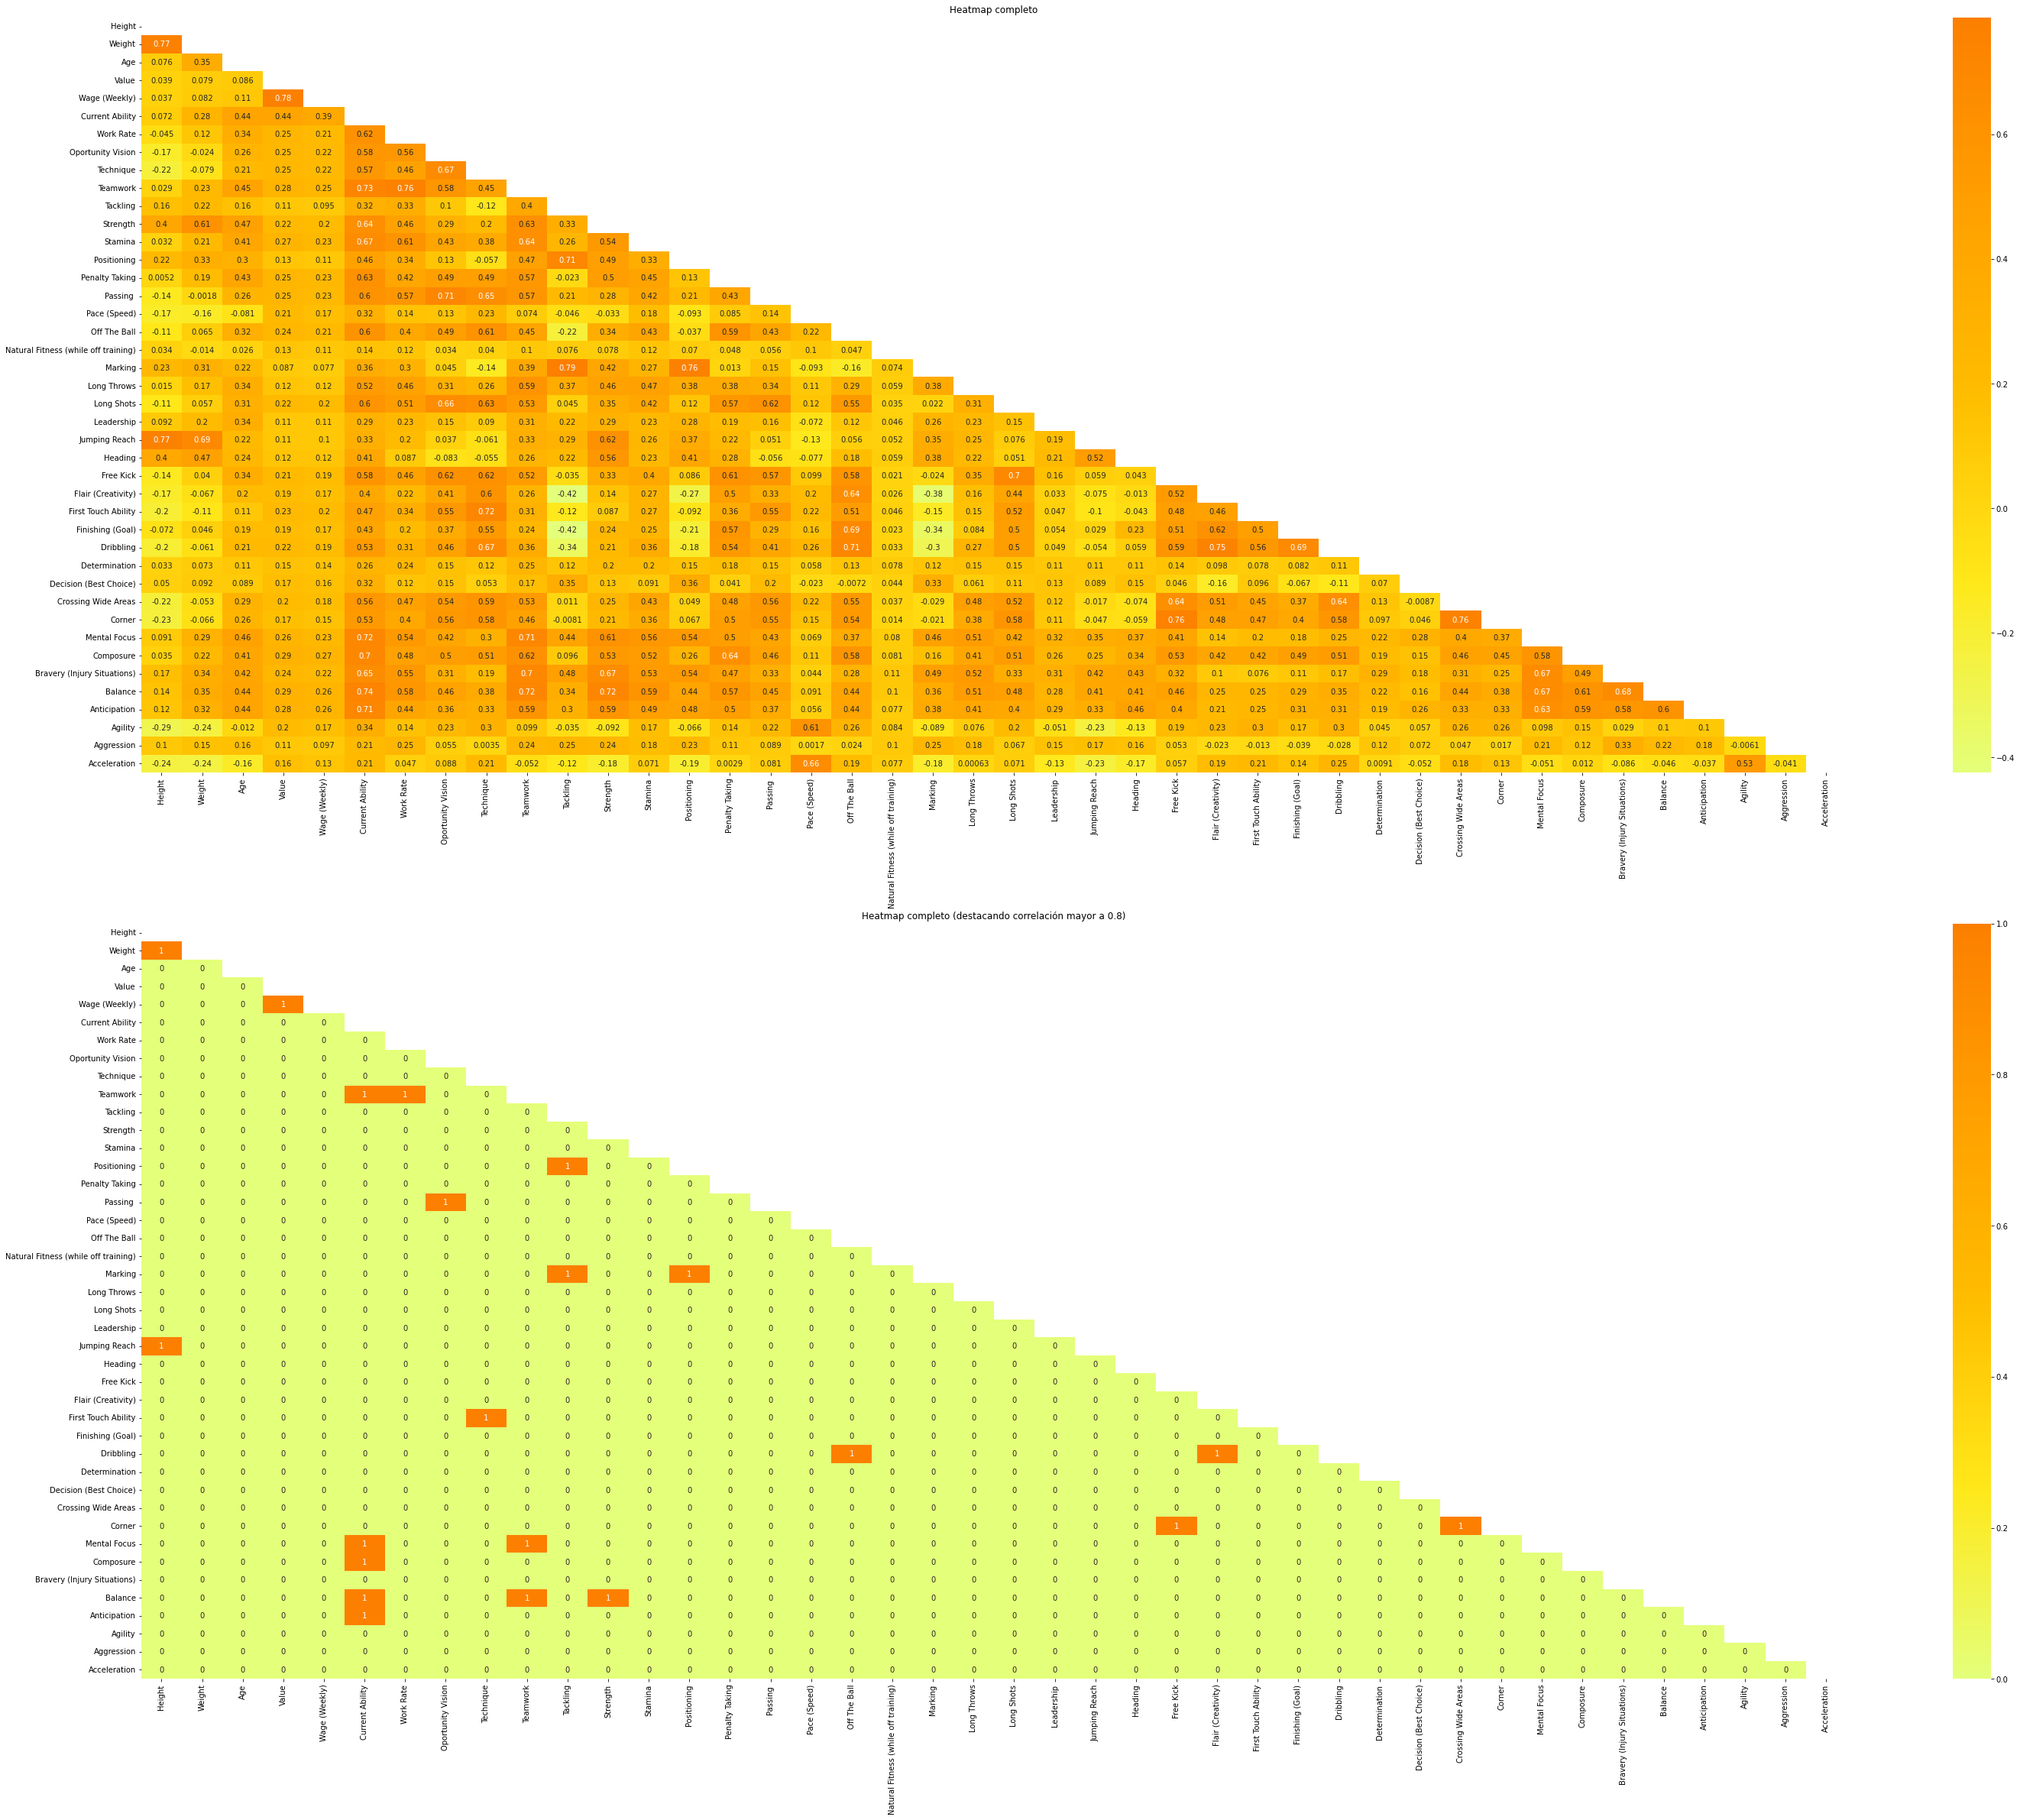

In [40]:
# Heatmap con data completa
fig, ax = plt.subplots(2, figsize=(50,40))

mask = np.triu(np.ones_like(df_regA2.corr(), dtype=bool))
mask2 = np.triu(np.ones_like(df_regA2.corr()>0.8, dtype=bool))
plot1 = sns.heatmap(df_regA2.corr(), annot=True, cmap='Wistia', mask=mask, ax=ax[0])
plot2 = sns.heatmap(df_regA2.corr()>0.7, annot=True, cmap='Wistia', mask=mask2, ax=ax[1])

ax[0].set_title('Heatmap completo')
ax[1].set_title('Heatmap completo (destacando correlación mayor a 0.8)')

plt.show()


In [41]:
df_regA3 = df_regA2[df_regA2.Value!=0]
df_regA3.shape

(21387, 61)

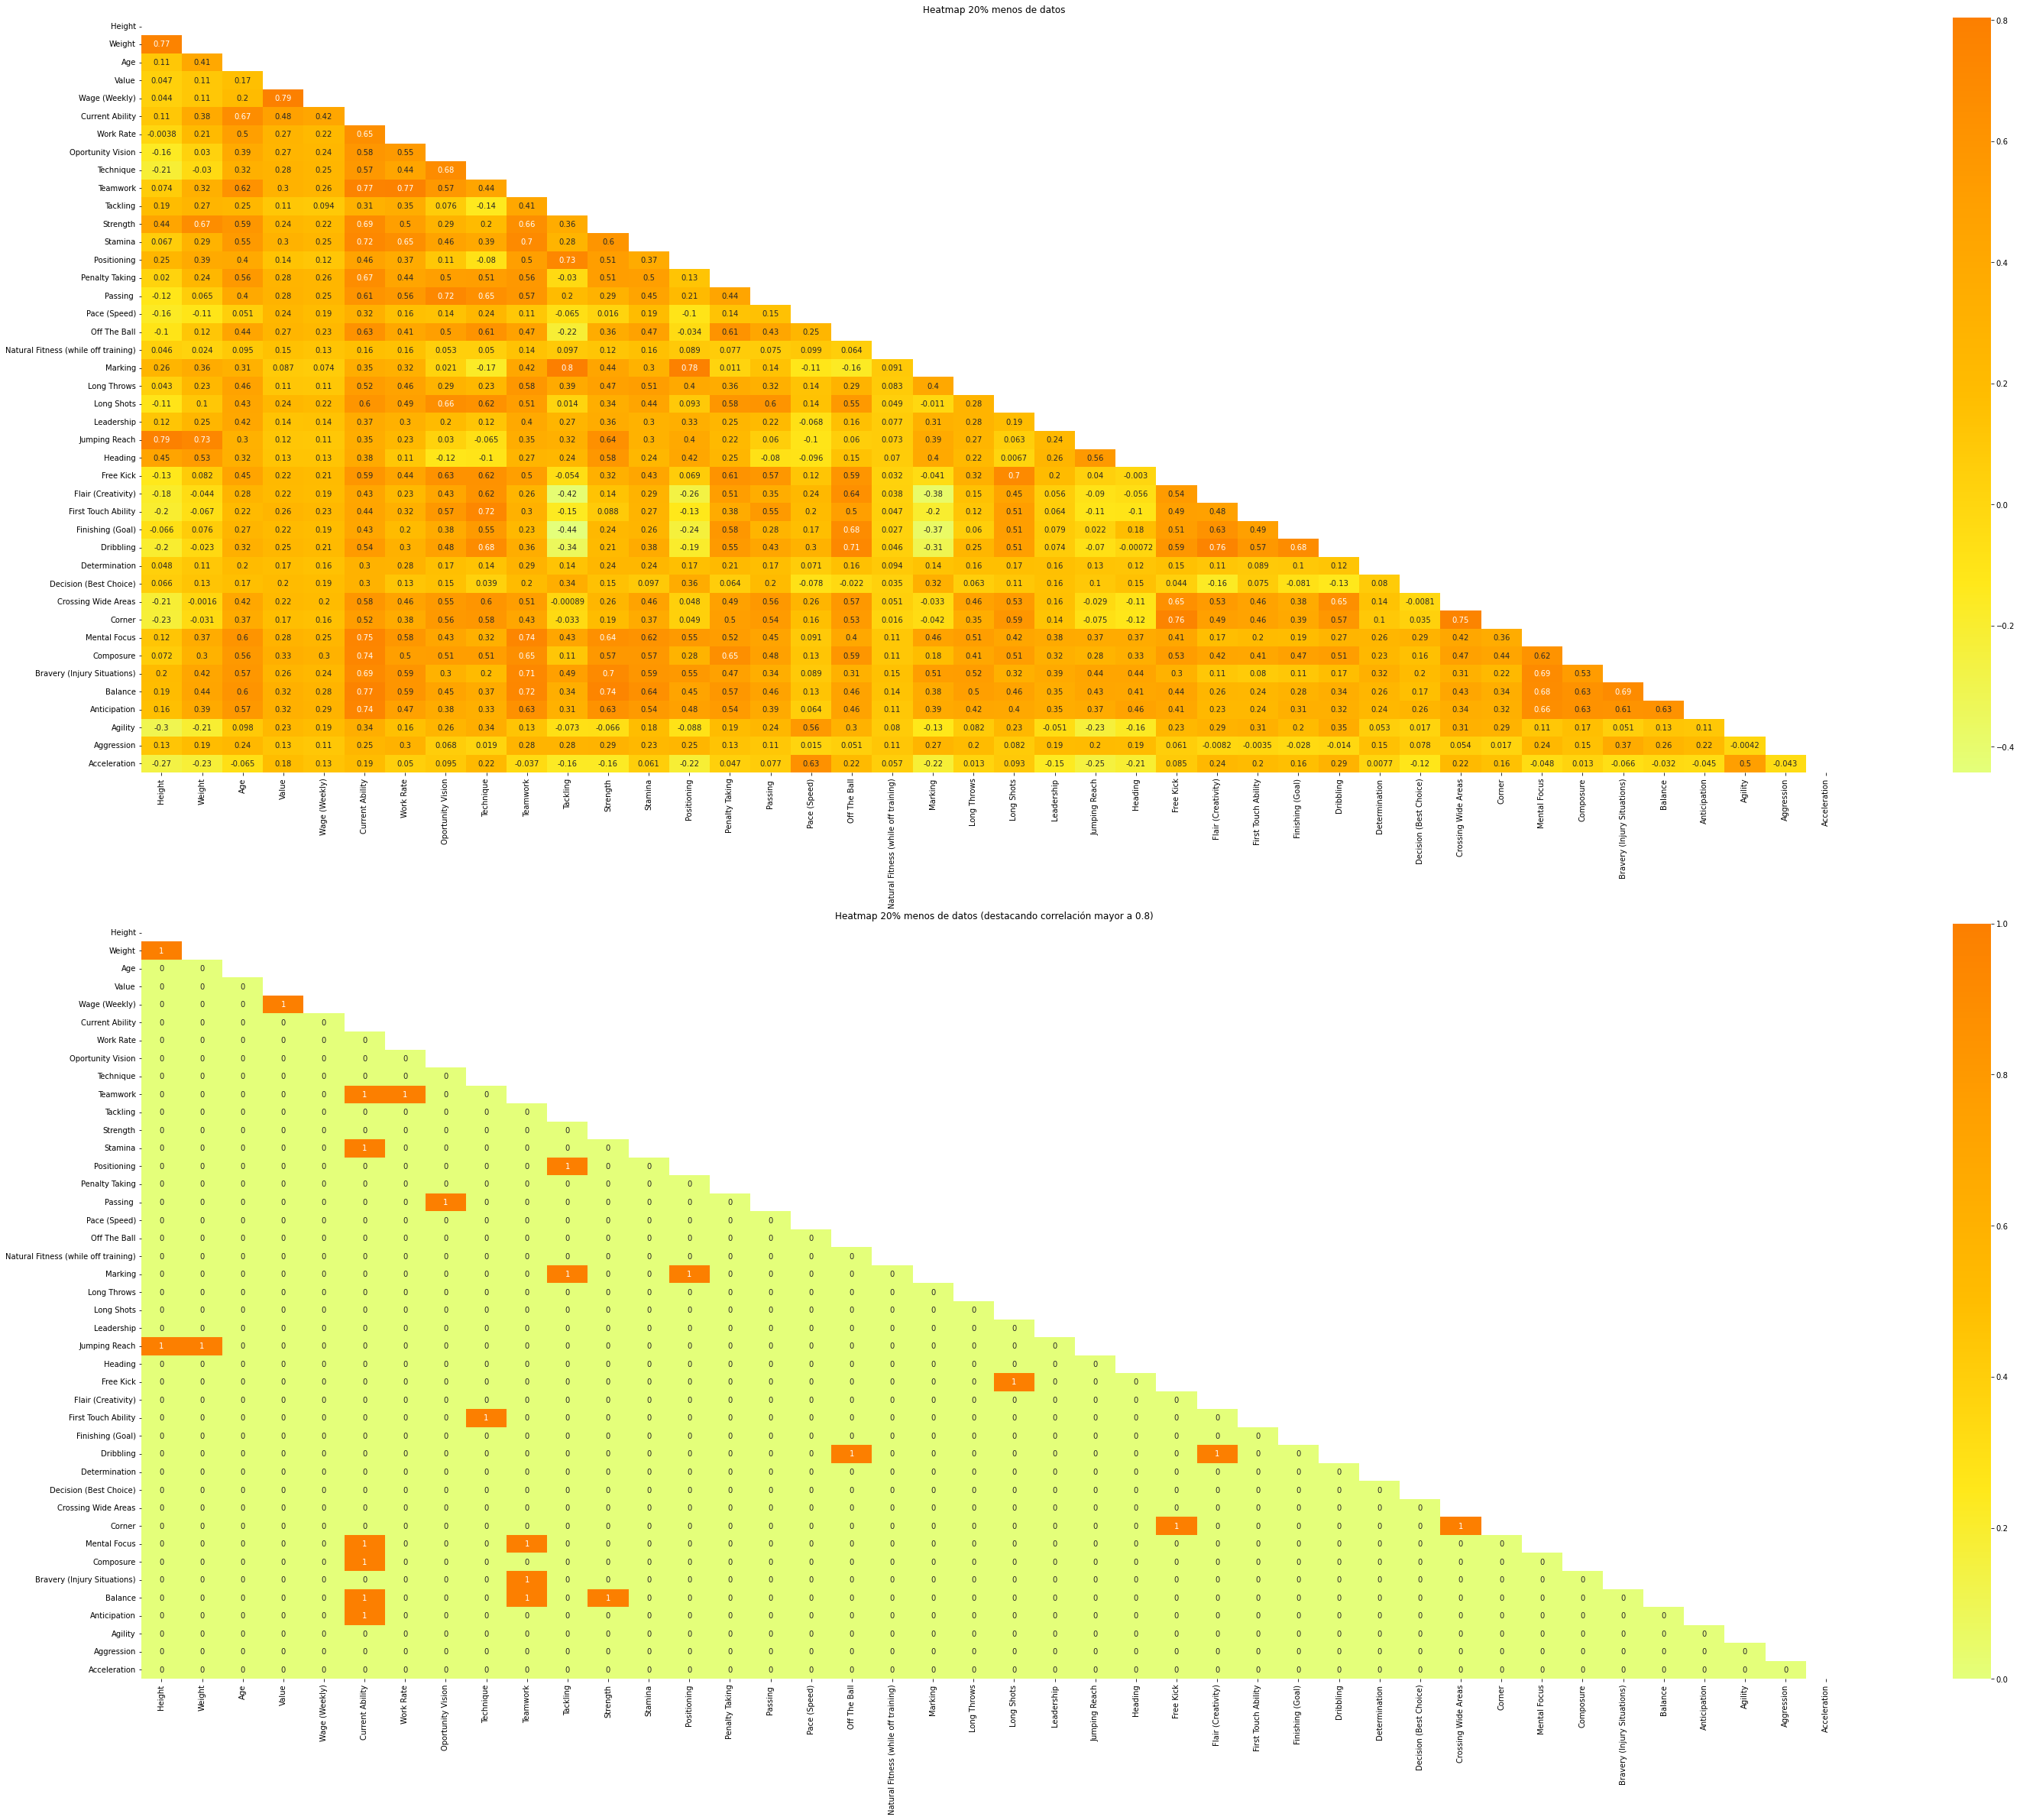

In [42]:
# Heatmap con data completa
fig, ax = plt.subplots(2, figsize=(50,40))

mask = np.triu(np.ones_like(df_regA3.corr(), dtype=bool))
mask2 = np.triu(np.ones_like(df_regA3.corr()>0.8, dtype=bool))
plot1 = sns.heatmap(df_regA3.corr(), annot=True, cmap='Wistia', mask=mask, ax=ax[0])
plot2 = sns.heatmap(df_regA3.corr()>0.7, annot=True, cmap='Wistia', mask=mask2, ax=ax[1])

ax[0].set_title('Heatmap 20% menos de datos')
ax[1].set_title('Heatmap 20% menos de datos (destacando correlación mayor a 0.8)')

plt.show()

Resignamos ese 20% de los datos y vemos como afecta al heatmap

No vemos variables que estén fuertemente correlacionadas con la variable objetivo (Value)

Pero sí vemos que hay algunas variables independientes que estan fuertemente correlacionadas entre sí, lo que podría generar problemas de inestabilidad en el modelo.

Al eliminar los valores 0 en la columna objetivo (Value), si bien vemos que el aumento de la correlación entre variables independientes aumenta, no lo hace de forma notable. Igual usaremos esta versión, ya que los valores nulos no tiene sentido estimarlos porque sabemos que no son datos reales
Vemos además que si incrementan su correlación entre variables independientes, lo que nos permite bajar la dimensionalidad del set de datos.



In [265]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

## Regresión de Random Forest

In [266]:
X = df_regA3.loc[:, df_regA3.columns != 'Value']
X= X.drop({
            'Name',
            'Position',
            'Club',
            'Division',
            'Based',
            'Nation_x',
            'Preferred Foot',
            'Best Pos',
            'Best Role','Pais_x',
            'Vehículo_x', 
            'Country_ENG', 
            'Country_Based', 
            'Pais_y',
            'Continent_Based', 
            'Nation_y', 
            'Vehículo_y',
            'Continente', 
            'Pos'}, axis=1)
y = df_regA3['Value']

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rfc=RandomForestRegressor(max_depth=4,random_state=123)
rfc.fit(X_train, y_train)


RandomForestRegressor(max_depth=4, random_state=123)

In [275]:
y_pred_rf=rfc.predict(X_test)
dicc={'Test':y_test,'Predicción':y_pred_rf}
pd.DataFrame.from_dict(dicc)

Test    Predicción
30947     10000  9.903701e+04
103313   155000  9.903701e+04
75566    200000  9.903701e+04
56363      3600  9.903701e+04
90097      4400  9.903701e+04
...         ...           ...
69865   2200000  9.396296e+05
106173    91000  9.903701e+04
104984    10000  9.903701e+04
129653    63000  9.903701e+04
19295   1300000  1.191579e+06

[6417 rows x 2 columns]

In [276]:
r2_score(y_test, y_pred_rf)

0.9041409433036682

In [277]:
# Evaluamos el modelo de RF
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

Mean Absolute Error: 567614.4332012722
Mean Squared Error: 2910446459353.805
Root Mean Squared Error: 1706003.0654585017


El R2 del modelo es bueno, por lo cual su predicción de variables será óptima

Ahora, para determinar la significatividad de las variables

In [278]:
dicc_fe={'Variable':X.columns,'Importancia':rfc.feature_importances_}
df_imp=pd.DataFrame.from_dict(dicc_fe)
df_imp[df_imp.Importancia>0.01]

Variable  Importancia
2              Age     0.033360
3    Wage (Weekly)     0.031686
4  Current Ability     0.929059

De esta manera, logramos bajar significativamente la dimensionalidad de nuestro data set

## Primer prueba de regresión lineal

In [279]:
# Probamos la regresión lineal con las variables importantes
X = df_regA3[['Age',
             'Wage (Weekly)',
             'Current Ability']]
y = df_regA3['Value']

In [280]:
# Entrenamiento vs test (70-30)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)

coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df 

-1475734.2175700753


Coefficient
Age             -195096.346647
Wage (Weekly)       157.295365
Current Ability   69798.874717

Podemos ver que la edad afecta de manera negativa el valor de un jugador, restándole casi 200 mil dolares a su valor promedio por cada año más, sin embargo, esto debe ser un fenómeno que comienza a suceder después del pico de su carrera, es decir, después de los 30 años.

En cuestión de salario, se intuía que este estaría fuertemente correlacionado con el valor del jugador, tan es así que un aumento en un dolar aumenta 157 dolares su valor, bastante considerando que si le aumentan a un jugador su salario en por ejemplo 10,000 dlls en un año, su valor tenderá a aumentar 1,570,000 dlls.

Por último la habilidad es la que tiene mayor impacto en el valor del jugador, un punto más de habilidad se traduce en casi 70,000 dlls más en el valor de mercado del jugador.

In [282]:
y_pred = regressor.predict(X_test)
y_pred

array([ -84388.43165616,  655872.50142995,  975649.13460655, ...,
        -11299.95495577, -878930.40105533, 2987488.07575551])

In [53]:
#Convertimos en df la salida
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

Actual     Predicted
30947     10000  6.566846e+05
103313   155000  1.200549e+06
75566    200000  1.187675e+06
56363      3600 -1.064870e+06
90097      4400 -9.387489e+05
...         ...           ...
69865   2200000  4.769857e+06
106173    91000 -1.935512e+06
104984    10000 -8.273023e+04
129653    63000 -1.094472e+06
19295   1300000  1.838987e+06

[6417 rows x 2 columns]

In [281]:
#Obtener P-value

beta_hat = [regressor.intercept_] + regressor.coef_.tolist()
beta_hat
# [0.18444290873001834, -1.5879784718284842, 2.5252138207251904]

n=len(X_train)


# compute the p-values
from scipy.stats import t
# add ones column
X1 = np.column_stack((np.ones(n), X_train))
# standard deviation of the noise.
sigma_hat = np.sqrt(np.sum(np.square(y_train - X1@beta_hat)) / (n - X1.shape[1]))
# estimate the covariance matrix for beta 
beta_cov = np.linalg.inv(X1.T@X1)
# the t-test statistic for each variable from the formula from above figure
t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
# compute 2-sided p-values.
p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
t_vals
# array([ 0.37424023, -2.36373529,  3.57930174])
p_vals

array([2.20054552e-031, 9.53479241e-153, 0.00000000e+000, 0.00000000e+000])

In [283]:
r2_score(y_test, y_pred)

0.7166587876536221

La significancia de las variables y el R2 son buenos, este último no explica del todo al modelo, pero dada la significancia podemos inferir que estas variables si influyen en el valor de un jugador

In [284]:
# Evaluacion del modelo
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1371218.246635238
Mean Squared Error: 8602728387729.764
Root Mean Squared Error: 2933040.809080188


## Boost

In [285]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
#import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error, explained_variance_score

In [286]:
cv = KFold(n_splits=10, random_state=123, shuffle=True)
model = LinearRegression()

MAE = make_scorer(mean_absolute_error)
MSE = make_scorer(mean_squared_error)
r2 = make_scorer(r2_score)

scores_mae = cross_val_score(model, X, y, scoring=MAE, verbose=1, cv=cv, n_jobs=1)
scores_mse = cross_val_score(model, X, y, scoring=MSE, verbose=1, cv=cv, n_jobs=1)
scores_r2 = cross_val_score(model, X, y, scoring=r2, verbose=1, cv=cv, n_jobs=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [287]:
var = make_scorer(explained_variance_score)
scores_var = cross_val_score(model, X, y, scoring=var, verbose=1, cv=cv, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [288]:
print('MAE : %.3f' % (np.mean(scores_mae)))
print('MSE : %.3f' %np.mean(scores_mse))
print('R2 : %.3f' %np.mean(scores_r2))

MAE : 1315438.191
MSE : 11155249765207.930
R2 : 0.640


In [289]:
#Obtener P-value

beta_hat = [regressor.intercept_] + regressor.coef_.tolist()
beta_hat
# [0.18444290873001834, -1.5879784718284842, 2.5252138207251904]


# compute the p-values
from scipy.stats import t
# add ones column
X1 = np.column_stack((np.ones(n), X_train))
# standard deviation of the noise.
sigma_hat = np.sqrt(np.sum(np.square(y_train - X1@beta_hat)) / (n - X1.shape[1]))
# estimate the covariance matrix for beta 
beta_cov = np.linalg.inv(X1.T@X1)
# the t-test statistic for each variable from the formula from above figure
t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
# compute 2-sided p-values.
p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
t_vals
# array([ 0.37424023, -2.36373529,  3.57930174])
p_vals

array([2.20054552e-031, 9.53479241e-153, 0.00000000e+000, 0.00000000e+000])

Utilizamos un Boost de K-fold para tratar de mejorar la regresión lineal, sin embargo, aunque los coeficientes siguen siendo significativos, el R2 disminuye, por lo cual preferimos quedarnos con el primer modelo

## Regresión en dos etapas

Hasta este punto, la hipótesis de que las habilidades particulares influirían en el valor del mercado se ha negado, sin embargo, las habilidades individuales si afectan la habilidad general, y esta a su vez afecta el valor del jugador, por lo cual optamos por último en utilizar un modelo de regresión lineal multiple en dos etapas, en la cual se hará una regresión con variables que afectan fuertemente a la habilidad general (tomadas del heat map), y a su vez se tomarán los valores predichos por estas para ver como interactuan con el valor del mercado, teniendo la habilidad general de por medio.

In [179]:
# Primera etapa
model_z = sm.OLS(df_regA3['Current Ability'], sm.add_constant(df_regA3[['Balance', 'Teamwork', 'Mental Focus','Composure','Anticipation']])).fit()



In [180]:
print(model_z.summary())

                            OLS Regression Results                            
Dep. Variable:        Current Ability   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                 1.523e+04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:36:09   Log-Likelihood:                -84202.
No. Observations:               21387   AIC:                         1.684e+05
Df Residuals:                   21381   BIC:                         1.685e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.9418      0.336     11.721   

La primer regresión nos muestra una fuerte correlación entre las variables independientes y la variable dependiente, con un R2 robusto y niveles de significancia buenos, y cada una fectando en por lo menos un punto de mejora en la habilidad general, por uno de la habilidad particular correspondiente.

Hasta aquí el modelo se muestra robusto.

In [181]:
# Predicciones de Z
Z_pred = model_z.predict(sm.add_constant(df_regA3[['Balance', 'Teamwork', 'Mental Focus','Composure','Anticipation']]))

In [182]:
Z_pred

363        97.863628
470        99.792844
501       103.267586
543        96.989832
784        92.749555
             ...    
144739    112.789425
144743    125.086490
144746    126.185887
144748    116.022072
144749    119.328447
Length: 21387, dtype: float64

In [183]:

# Modelo de regresión
#model_y = sm.OLS(Y, sm.add_constant(Z_pred)).fit()

model_y = sm.OLS(df_regA3['Value'], sm.add_constant(pd.concat([Z_pred, df_regA3[['Balance', 'Teamwork', 'Mental Focus','Composure','Anticipation']]], axis=1))).fit()

In [184]:
print(model_y.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     686.7
Date:                Wed, 29 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:36:16   Log-Likelihood:            -3.6118e+05
No. Observations:               21387   AIC:                         7.224e+05
Df Residuals:                   21381   BIC:                         7.224e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.658e+06   7.96e+04    -45.978   

Al llegar a la segunda etapa, vemos que las variables seleccionadas si tienen significancia con la variable dependiente, sin embargo el R2 es bajo, explica pobremente al modelo, por lo cual, aunque estas variables explican la habilidad general, y esta a su vez explica el valor del jugador, no parece haber conexión directa entre los extremos, por lo cual nos quedamos de nuevo con la primer regresión lineal.

# Resultados y Conclusiones

Desfortunadamente no pudimos corroborar nuestra principal hipótesis que era comprobar si había relación directa entre las habilidades particulares de un jugador y su valor en el mercado, los modelos propuestos nos dieron como resultado características muy limitadas en lo que corresponde a explicar esta varible dependiente; es casi obvio que la edad, el salario y la habilidad general del jugador indluirán en su valor de mercado, sin embargo, esperabamos encontrar más con esta investigación, una explicación más robusta sobre su valor basados en sus habilidades.

Aún así, lo encontrado, aunque poco, es un resultado robusto, una relación negativa del valor con la edad de 195096.34 dlls, es algo que cumple con los supuestos del mercado de que a mayor edad, el jugador tenderá a perder capacidades y por lo tanto valor. La correlación con el salario nos muestra como un aumento en el mismo puede aumentar su valoren una relación de más de 100 a 1, aunque este es un resultado que queda para debatirse, pues esta relación también se puede encontrar a la inversa, con lo cual se puede analizar en un segundo estudio el posible problema de endogeneidad aquí visto.

Por último podríamos decir que nuestra hipótesis no estaba tan alejada de la realidad, pues la habilidad general si influye, y bastante en el valor del jugaodor, en 69798.874717 dlls por cada punto aumentado, por lo cual, aunque no encontramos relación directa con habilidades particulares, si podemos cuantificar en general el impacto de que un jugador hacienda en su nivel general de juego.

Para finalizar, vemos factible seguir con la investigación, pues en la regresión en dos etapas si notamos correlación directa entre el valor y las habilidades particulares, lo cual nos hace creer que bajo los supuestos adecuados y haciendo las delimitaciones necesarias, podemos encontrar impacto de estas variables en el valor de un jugador.




# Anexo (Otros experimentos)

En esta parte mostramos otros experimentos realizados que tratamos de incluir en el ejercicio pero que no encontramos salida.

Número uno, un K means para encontrar el jugador promedio con base a las variables importantes que encontramos en la sección anterior, agrupandolos en 3 puntos, buscando entender si la edad influía en el valor y la habilidad general y encontrando el jugador que representará cada grupo de edad, joven, top, en declive.

Aunque el modelo se ejecutó correctamente, encontrar al jugador más cercano al centroide no se logró, los diferentes métodos que utilizamos para ello fallaron y por ello quedó solo en un intento.

En segunda instancia otro experimento que hicimos fue uno igual al aquí reportado, sin embargo separando el dataframe por posiciones de juego, defensa, medio y atacante, esperando encontrar si de esa manera, las habilidades particulares tomabana mayor relevancia, sin embargo, los resultados fueron muy similares al obtenido en el ejercicio principal en todos los casos, por ello lo dejamos solo como un experimento inconcluso.

## K-means


In [293]:

XX=df_regA3[['Age',
             'Current Ability',
             'Value'
             ]]


In [294]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances


In [295]:
#Definir Número de clusters
kmeans = KMeans(n_clusters=3)

# Entrena el modelo
kmeans.fit(XX)

# Obtiene las etiquetas de cada muestra
labels = kmeans.labels_

# Obtiene los centroides finales
centroids = kmeans.cluster_centers_


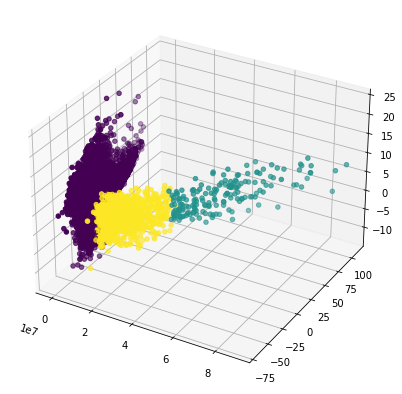

In [300]:

# Import libraries
from mpl_toolkits import mplot3d

# Aplica PCA para reducir la dimensionalidad a 2
pca = PCA(n_components=3)
X_pca = pca.fit_transform(XX)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Grafica los puntos coloreados según su cluster
ax.scatter3D(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2], c=labels)
plt.show()


In [297]:
centroids


array([[2.19358040e+01, 8.97768054e+01, 5.50440641e+05],
       [2.56000000e+01, 1.58914286e+02, 4.90457143e+07],
       [2.53425560e+01, 1.38903821e+02, 1.65355731e+07]])

In [298]:
# Create a function to find the closest centroids.
def findClosestCentroids(X, centroids):
    """
    Returns the closest centroids in idx for a dataset X
    where each row is a single example. idx = m x 1 vector
    of centroid assignments (i.e. each entry in range [1..K])
    Args:
        X        : array(# training examples, n)
        centroids: array(K, n)
    Returns:
        idx      : array(# training examples, 1)
    """
    # Set K size.
    K = centroids.shape[0]

    # Initialise idx.
    idx = np.zeros((X.shape[0], 1), dtype=np.int8)

    # Iterate over every example, find its closest centroid, and store
    # the index inside idx at the appropriate location. Concretely,
    # idx[i] should contain the index of the centroid closest to
    # example i. Hence, it should be a value in the range 1..K.
    
#     # Iterate over training examples.
#     for i in range(X.shape[0]):
#         # Set norm distance to infinity.
#         min_dst = math.inf
#         # Iterate over centroids.
#         for k in range(K):
#             # Compute the norm distance.
#             dst = np.linalg.norm(X[i,:] - centroids[k,:], axis=0)
#             if dst < min_dst:
#                 min_dst = dst
#                 idx[i] = k
    
    # Alternative partial vectorized solution.
    # Iterate over training examples.
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        # argmin returns the indices of the minimum values along an axis,
        # replacing the need for a for-loop and if statement.
        min_dst = np.argmin(distances)
        idx[i] = min_dst
    
    return idx

In [299]:
# # Find the closest centroids for the examples.
# idx = findClosestCentroids(XX, centroids)

# # print('Closest centroids for the first 3 examples: \n')
# # print(idx[:3])
# # print('\n(The closest centroids should be 0, 2, 1 respectively)')

In [291]:
distances = cdist(XX, centroids)

# Obtiene el índice del punto más cercano a cada centroide
closest_points = np.argmin(distances, axis=0)

# # Imprime el índice y la coordenada del punto más cercano a cada centroide
# for i, centroid in enumerate(centroids):
#     print(f"Punto más cercano al centroide {i}: {XX[closest_points[i]]}")
#     print(i)


## Regresión agrupando por posición

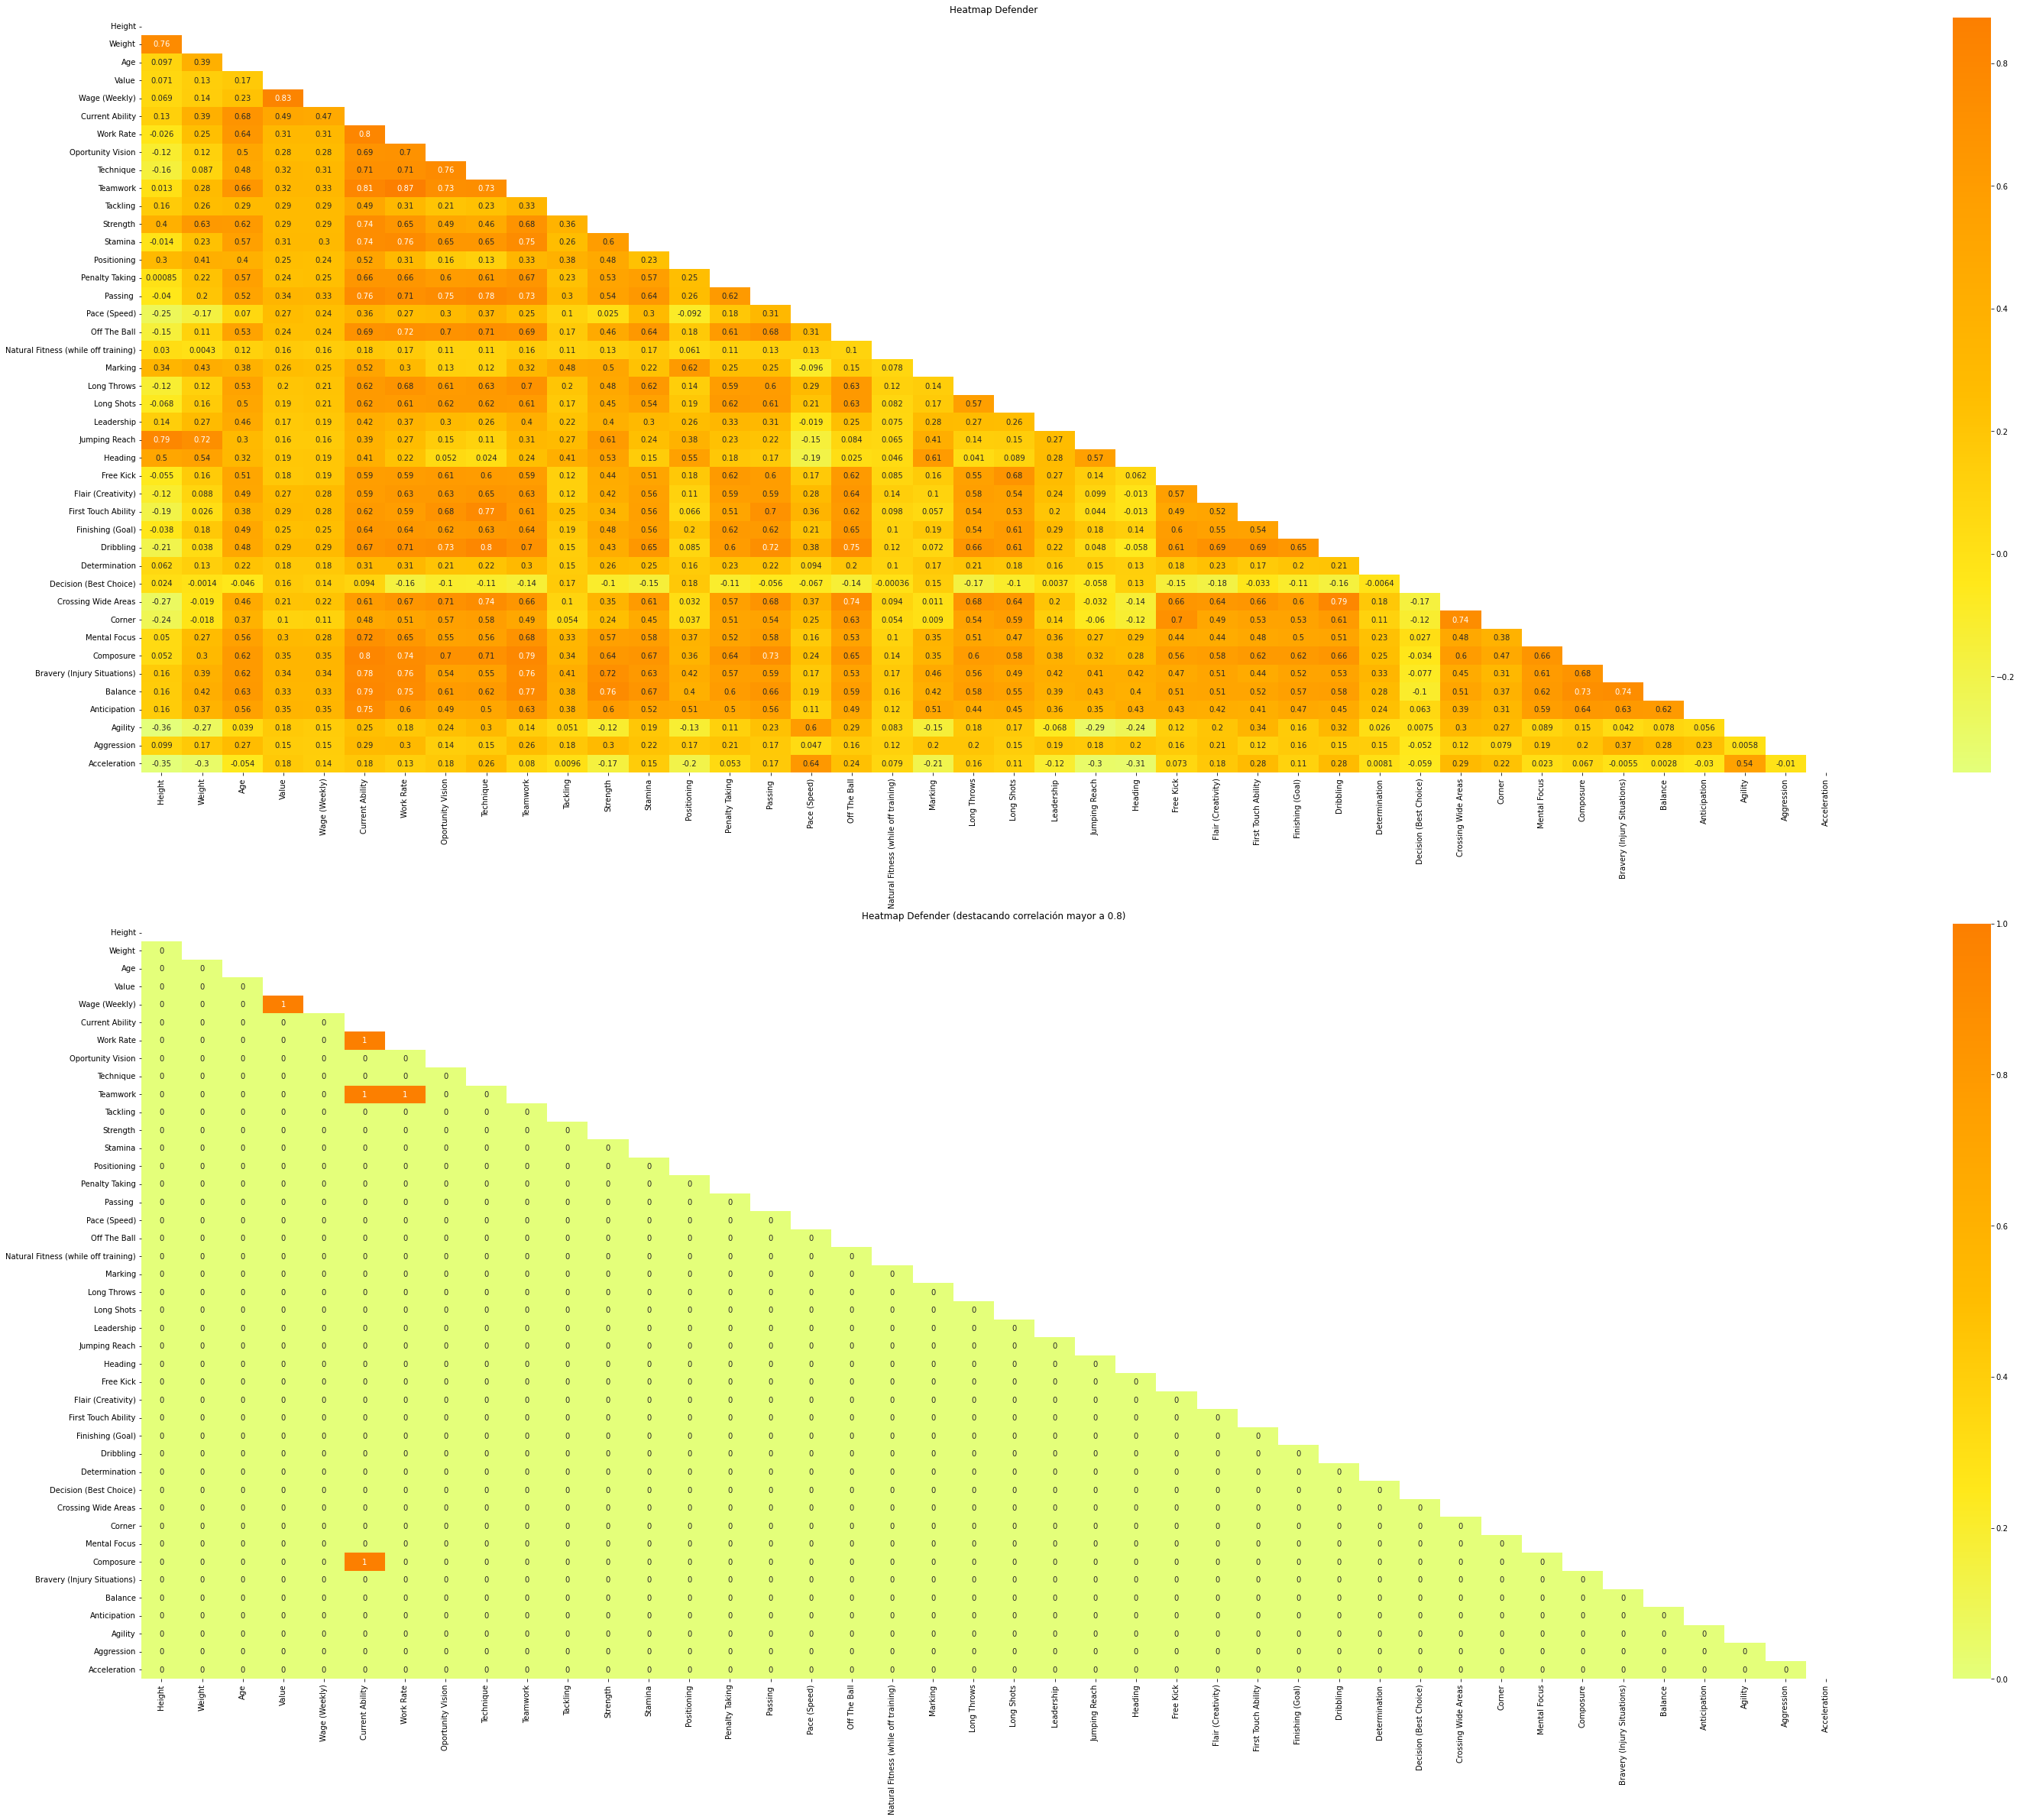

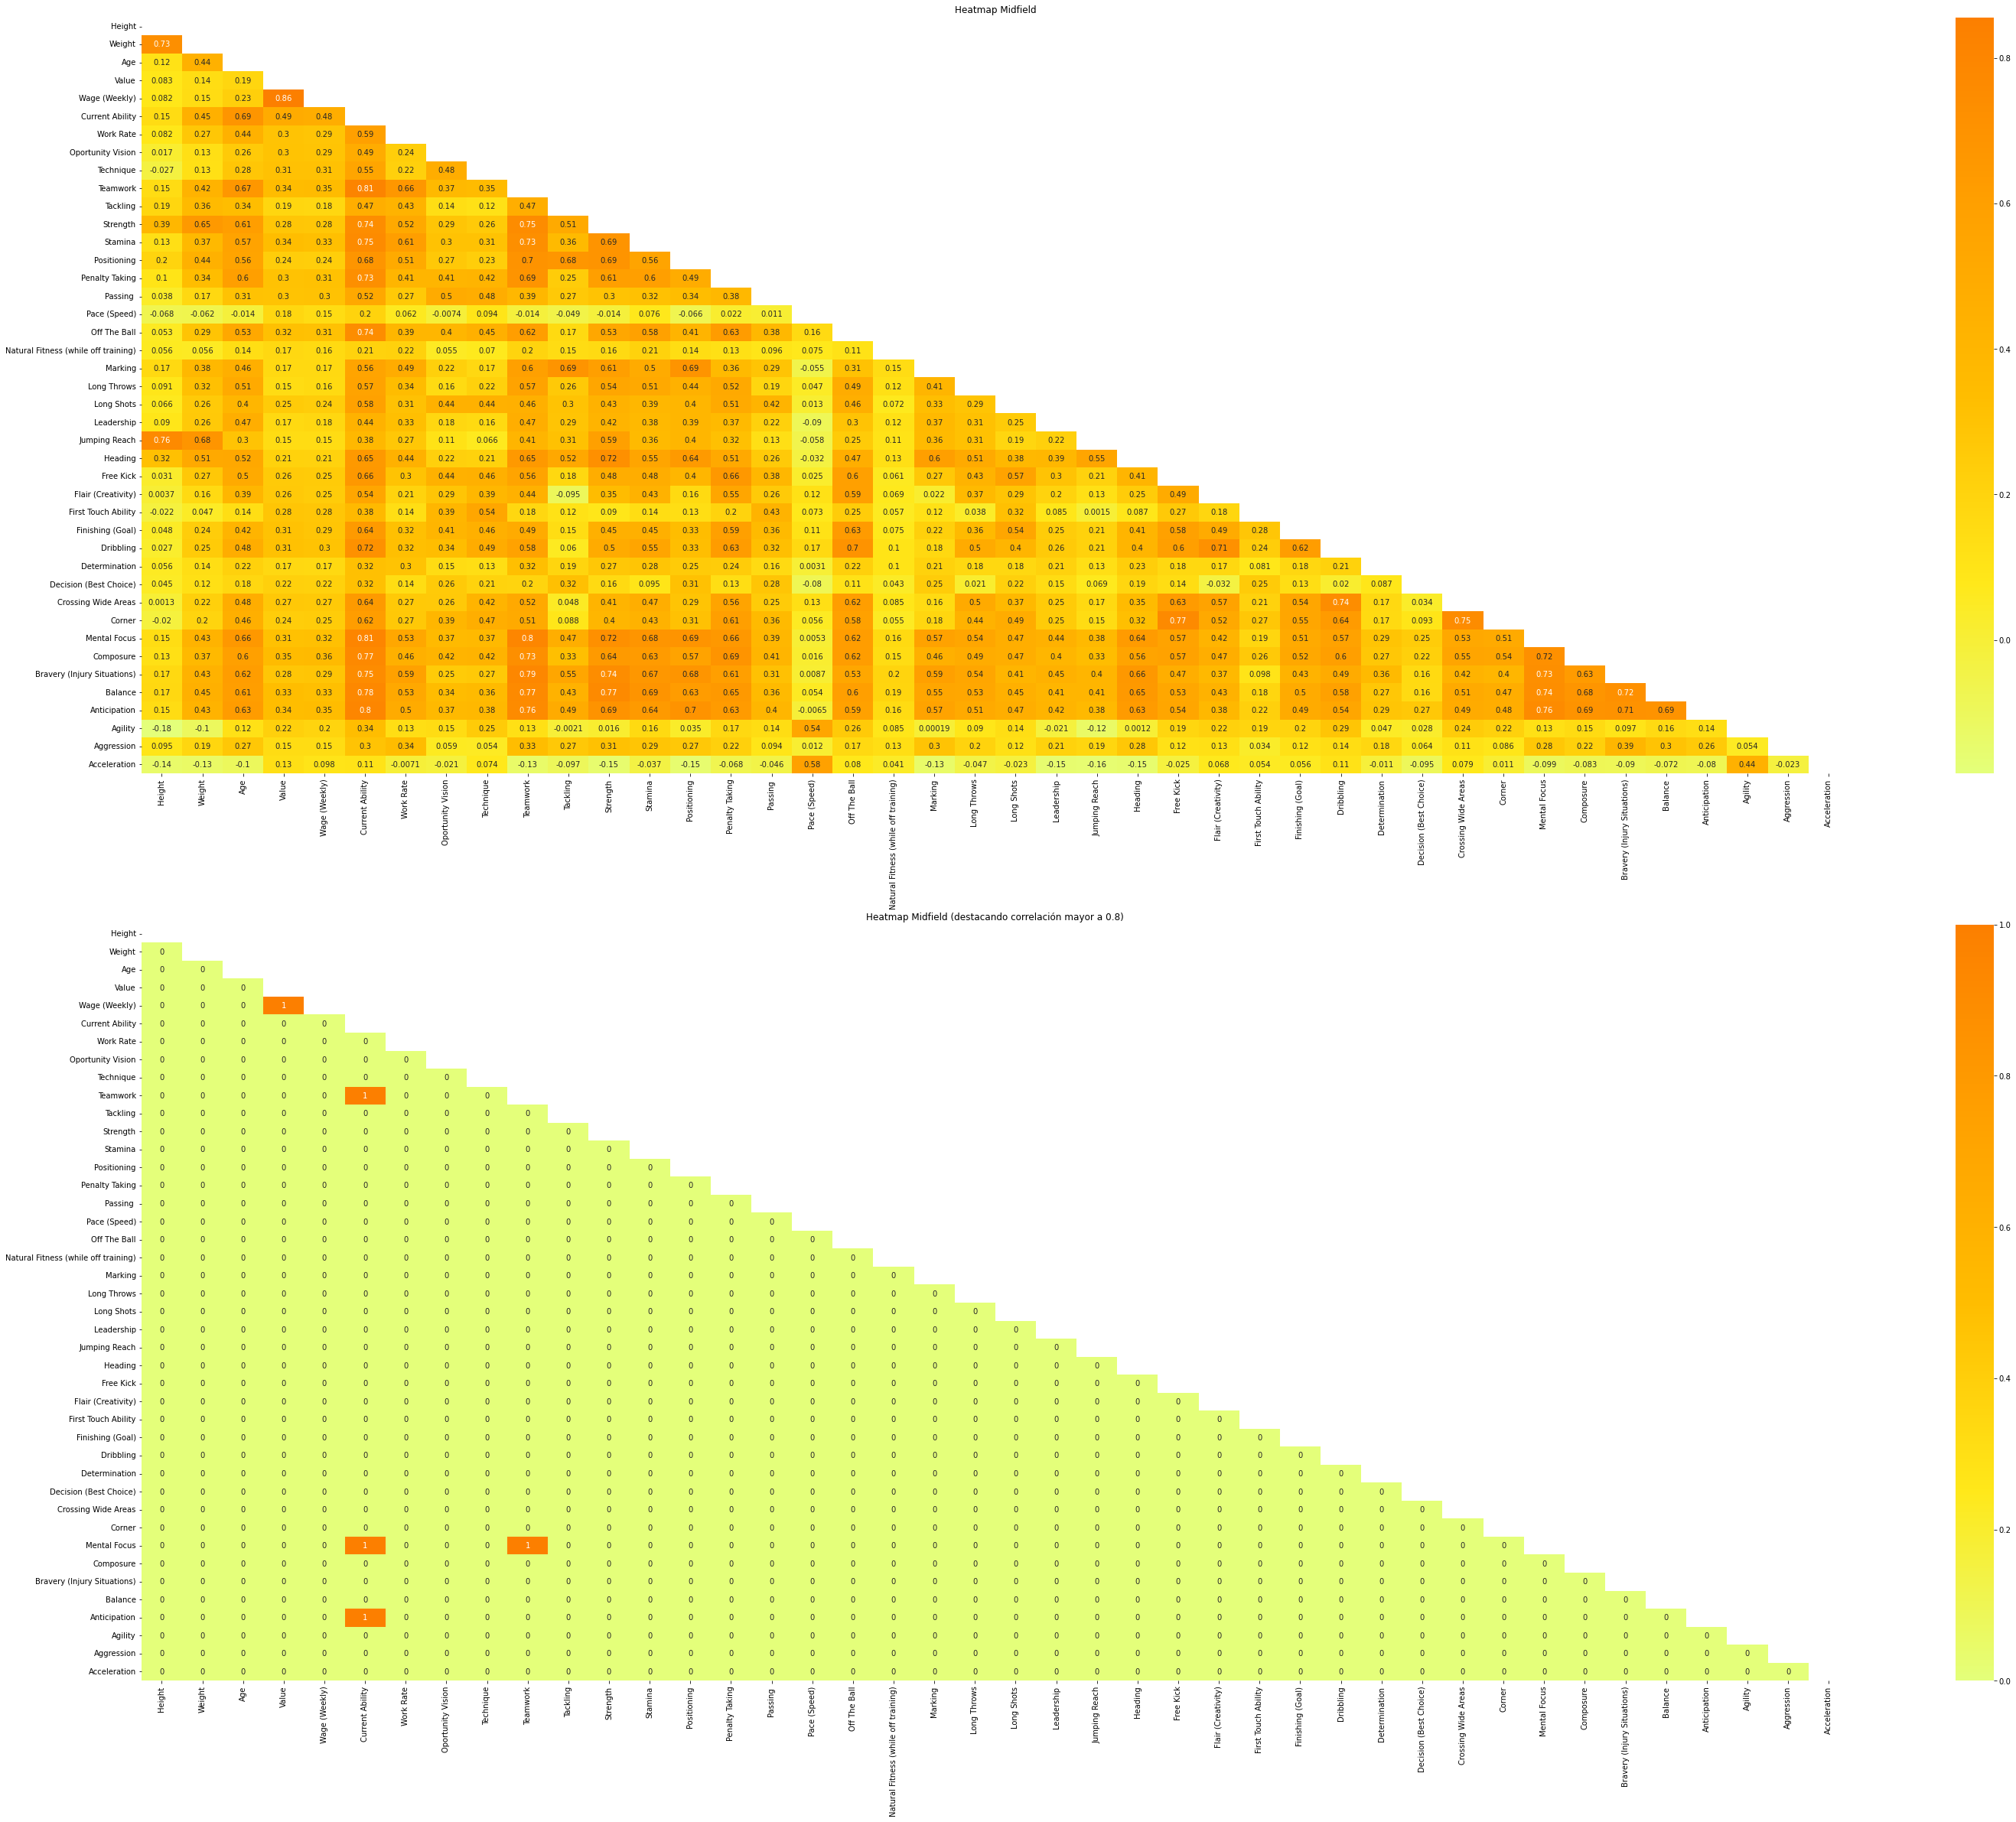

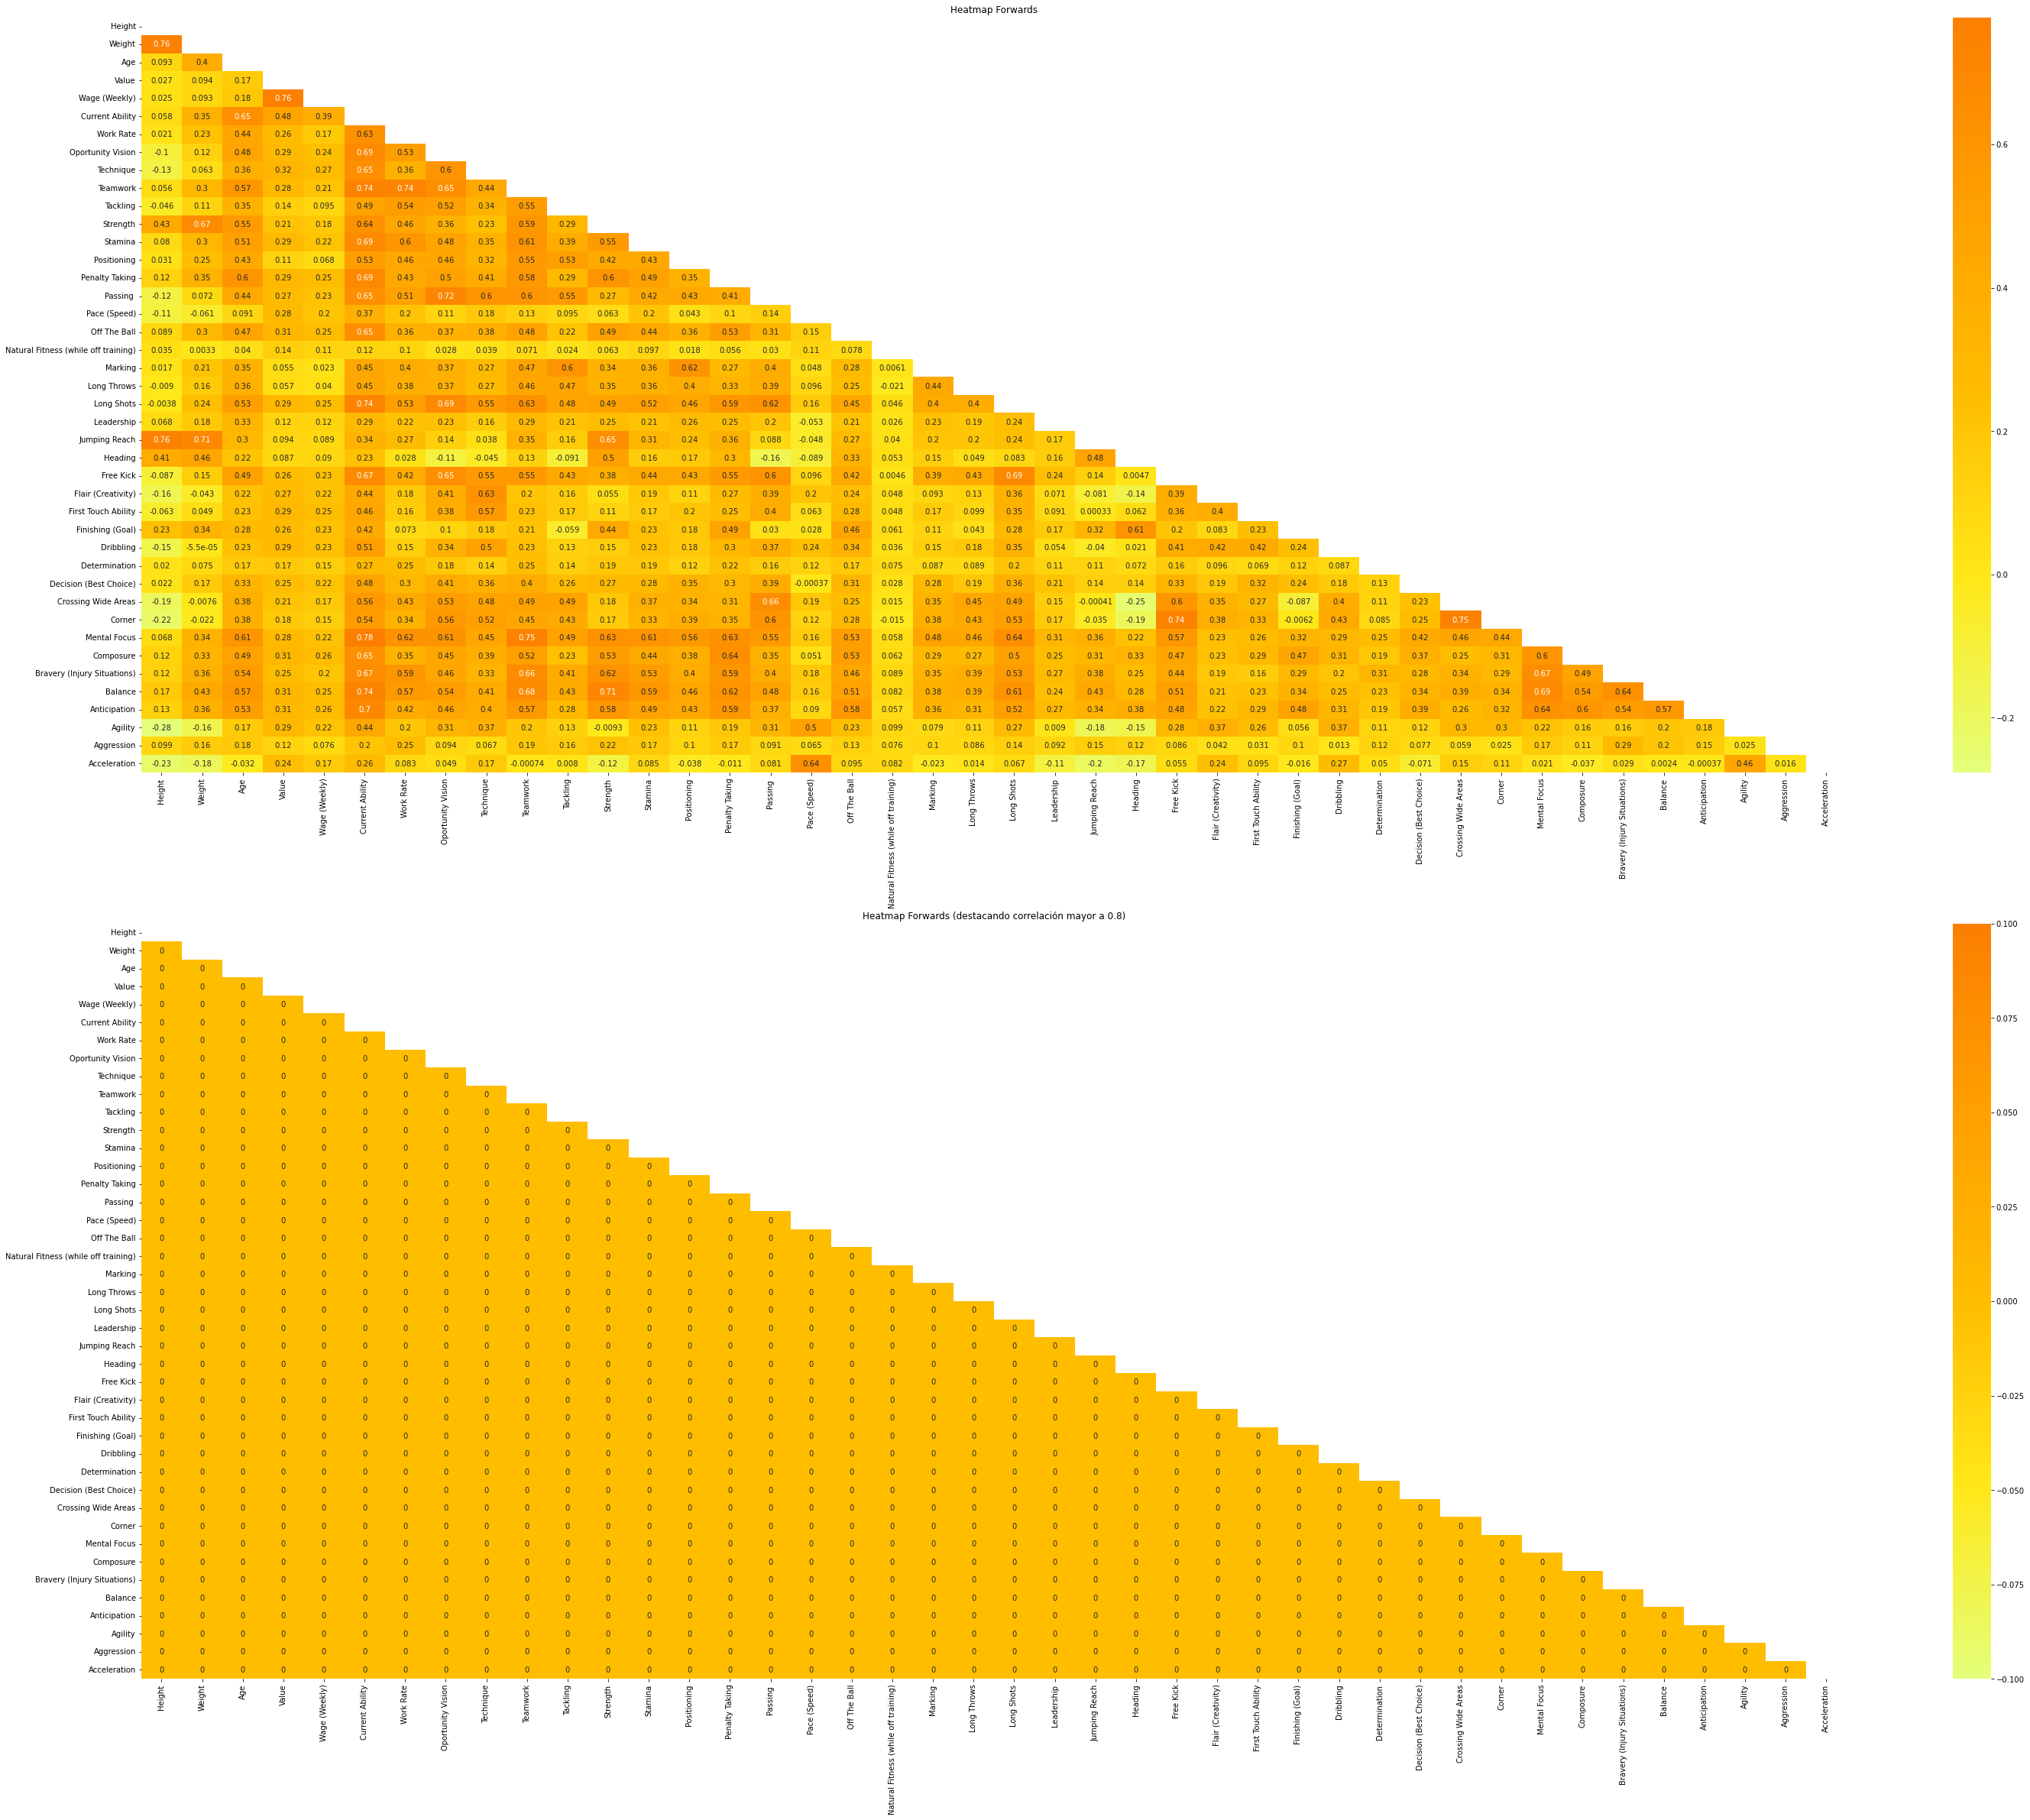

In [301]:
positions = ['Defender', 'Midfield', 'Forwards']

for pos in positions:


    fig, ax = plt.subplots(2, figsize=(50,40))

    mask = np.triu(np.ones_like(df_regA3[df_regA3.Pos==f'{pos}'].corr(), dtype=bool))
    mask2 = np.triu(np.ones_like(df_regA3[df_regA3.Pos==f'{pos}'].corr()>0.8, dtype=bool))
    plot1 = sns.heatmap(df_regA3[df_regA3.Pos==f'{pos}'].corr(), annot=True, cmap='Wistia', mask=mask, ax=ax[0])
    plot2 = sns.heatmap(df_regA3[df_regA3.Pos==f'{pos}'].corr()>0.8, annot=True, cmap='Wistia', mask=mask2, ax=ax[1])

    ax[0].set_title(f'Heatmap {pos}')
    ax[1].set_title(f'Heatmap {pos} (destacando correlación mayor a 0.8)')

    plt.show()


In [302]:
positions = ['Defender', 'Midfield', 'Forwards']

for pos in positions:
    df = df_regA3[df_regA3.Pos==f'{pos}']
    X = df.loc[:, df.columns != 'Value']
    X= X.drop({
            'Name',
            'Position',
            'Club',
            'Division',
            'Based',
            'Nation_x',
            'Preferred Foot',
            'Best Pos',
            'Best Role','Pais_x',
            'Vehículo_x', 
            'Country_ENG', 
            'Country_Based', 
            'Pais_y',
            'Continent_Based', 
            'Nation_y', 
            'Vehículo_y',
            'Continente', 
            'Pos'}, axis=1)
    y = df['Value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    print(f'---------{pos} Simple Validation Linear Regression---------------')
    print(f'{pos} Regressor Intercept: ',regressor.intercept_)

    #coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
    #print('Coeficientes')
    #print(coeff_df) 

    y_pred = regressor.predict(X_test)

    # Evaluacion del modelo
    print(f'{pos} R2: ', metrics.r2_score(y_test, y_pred))
    print(f'{pos} Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred))
    print(f'{pos} Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred))
    print(f'{pos} Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('')

    print(f'---------{pos} Random forest---------------')
    print('')

    rfc=RandomForestRegressor(max_depth=4,random_state=123)
    rfc.fit(X_train, y_train)

    y_pred_rf=rfc.predict(X_test)
    dicc={'Test':y_test,'Predicción':y_pred_rf}
    pd.DataFrame.from_dict(dicc)

    print(f'{pos} R2: ', metrics.r2_score(y_test, y_pred_rf))
    print(f'{pos} Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred_rf))
    print(f'{pos} Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_rf))
    print(f'{pos} Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
    print('')

    print(f'---------{pos} Feature Importances---------------')
    dicc_fe={'Variable':X.columns,'Importancia':rfc.feature_importances_}
    df_imp=pd.DataFrame.from_dict(dicc_fe)
    print(df_imp[df_imp.Importancia>0.01])
    print('')


---------Defender Simple Validation Linear Regression---------------
Defender Regressor Intercept:  -4461747.365557659
Defender R2:  0.7463022985569105
Defender Mean Absolute Error:  1063827.0024166992
Defender Mean Squared Error:  5809866643781.69
Defender Root Mean Squared Error:  2410366.495739121

---------Defender Random forest---------------

Defender R2:  0.8551921787685357
Defender Mean Absolute Error:  551645.1693183186
Defender Mean Squared Error:  3316207145535.031
Defender Root Mean Squared Error:  1821045.6187407912

---------Defender Feature Importances---------------
          Variable  Importancia
2              Age     0.025695
3    Wage (Weekly)     0.055770
4  Current Ability     0.892461

---------Midfield Simple Validation Linear Regression---------------
Midfield Regressor Intercept:  -1272265.6090365683
Midfield R2:  0.7933830264003143
Midfield Mean Absolute Error:  1185005.5249191255
Midfield Mean Squared Error:  7346983374684.859
Midfield Root Mean Squared Erro

In [303]:
# Hacemos Regresion y RF nuevamente

for pos in positions:
    df = df_regA3[df_regA3.Pos==f'{pos}']
    X = df[['Age',
        'Wage (Weekly)',
        'Current Ability']]
    y = df['Value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    print(f'---------{pos} Simple Validation Linear Regression---------------')
    print(f'{pos} Regressor Intercept: ',regressor.intercept_)

    #coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
    #print('Coeficientes')
    #print(coeff_df) 

    y_pred = regressor.predict(X_test)

    # Evaluacion del modelo
    print(f'{pos} R2: ', metrics.r2_score(y_test, y_pred))
    print(f'{pos} Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred))
    print(f'{pos} Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred))
    print(f'{pos} Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('')

    print(f'---------{pos} Random forest---------------')

    rfc=RandomForestRegressor(max_depth=4,random_state=123)
    rfc.fit(X_train, y_train)

    y_pred_rf=rfc.predict(X_test)
    dicc={'Test':y_test,'Predicción':y_pred_rf}
    pd.DataFrame.from_dict(dicc)

    print(f'{pos} R2: ', metrics.r2_score(y_test, y_pred_rf))
    print(f'{pos} Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred_rf))
    print(f'{pos} Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_rf))
    print(f'{pos} Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
    print('')

    
    print(f'---------{pos} KFold---------------')

    cv = KFold(n_splits=10, random_state=123, shuffle=True)
    model = RandomForestRegressor()

    MAE = make_scorer(mean_absolute_error)
    MSE = make_scorer(mean_squared_error)
    r2 = make_scorer(r2_score)

    scores_mae = cross_val_score(model, X, y, scoring=MAE, verbose=1, cv=cv, n_jobs=1)
    scores_mse = cross_val_score(model, X, y, scoring=MSE, verbose=1, cv=cv, n_jobs=1)
    scores_r2 = cross_val_score(model, X, y, scoring=r2, verbose=1, cv=cv, n_jobs=1)

    print(f'{pos} MAE : %.3f' % (np.mean(scores_mae)))
    print(f'{pos} MSE : %.3f' %np.mean(scores_mse))
    print(f'{pos} R2 : %.3f' %np.mean(scores_r2))
    print('')


---------Defender Simple Validation Linear Regression---------------
Defender Regressor Intercept:  -736028.4621735674
Defender R2:  0.7425333421293361
Defender Mean Absolute Error:  1045021.1614972231
Defender Mean Squared Error:  5896178557945.181
Defender Root Mean Squared Error:  2428204.8014830174

---------Defender Random forest---------------
Defender R2:  0.8826650835646971
Defender Mean Absolute Error:  528728.4950588441
Defender Mean Squared Error:  2687057128506.543
Defender Root Mean Squared Error:  1639224.5509711422

---------Defender KFold---------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Defender MAE : 431333.086
Defender MSE : 2332939441212.550
Defender R2 : 0.888

---------Midfield Simple Validation Linear Regression---------------
Midfield Regressor Intercept:  -320691.96741271927
Midfield R2:  0.7931157112475994
Midfield Mean Absolute Error:  1131373.8130739902
Midfield Mean Squared Error:  7356488692416.422
Midfield Root Mean Squared Error:  2712284.7734735417

---------Midfield Random forest---------------
Midfield R2:  0.9049482425314285
Midfield Mean Absolute Error:  573782.9237553277
Midfield Mean Squared Error:  3379895028417.1377
Midfield Root Mean Squared Error:  1838449.0823564131

---------Midfield KFold---------------


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished


Midfield MAE : 495848.051
Midfield MSE : 3215393530246.702
Midfield R2 : 0.891

---------Forwards Simple Validation Linear Regression---------------
Forwards Regressor Intercept:  -2533808.401617773
Forwards R2:  0.703069399997208
Forwards Mean Absolute Error:  1605908.7539928323
Forwards Mean Squared Error:  9603683249257.234
Forwards Root Mean Squared Error:  3098981.0017580353

---------Forwards Random forest---------------
Forwards R2:  0.9099062152842184
Forwards Mean Absolute Error:  556384.0471197725
Forwards Mean Squared Error:  2913920529339.19
Forwards Root Mean Squared Error:  1707020.9516403687

---------Forwards KFold---------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Forwards MAE : 501293.360
Forwards MSE : 3086398073138.096
Forwards R2 : 0.923



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished


In [304]:
# Reg con posicion

reg = df_regA3.replace({'Defender':1,
                        'Midfield':2,
                        'Forwards':3})



X = reg[['Age',
    'Wage (Weekly)',
    'Current Ability',
    'Pos']]
y = reg['Value']


In [305]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(f'--------- Simple Validation Linear Regression---------------')
print(f'Regressor Intercept: ',regressor.intercept_)

#coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
#print('Coeficientes')
#print(coeff_df) 

y_pred = regressor.predict(X_test)

# Evaluacion del modelo
print(f' R2: ', metrics.r2_score(y_test, y_pred))
print(f' Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred))
print(f' Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred))
print(f' Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


print(f'--------- Random forest---------------')
print('')

rfc=RandomForestRegressor(max_depth=4,random_state=123)
rfc.fit(X_train, y_train)

y_pred_rf=rfc.predict(X_test)
dicc={'Test':y_test,'Predicción':y_pred_rf}
pd.DataFrame.from_dict(dicc)

print(f' R2: ', metrics.r2_score(y_test, y_pred_rf))
print(f' Mean Absolute Error: ', metrics.mean_absolute_error(y_test, y_pred_rf))
print(f' Mean Squared Error: ', metrics.mean_squared_error(y_test, y_pred_rf))
print(f' Root Mean Squared Error: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('')

print(f'--------- Feature Importances---------------')
dicc_fe={'Variable':X.columns,'Importancia':rfc.feature_importances_}
df_imp=pd.DataFrame.from_dict(dicc_fe)
print(df_imp[df_imp.Importancia>0.01])
print(df_imp[df_imp.Variable=='Pos'])


--------- Simple Validation Linear Regression---------------
Regressor Intercept:  -1469297.429333556
 R2:  0.7166514627416096
 Mean Absolute Error:  1371271.1835612168
 Mean Squared Error:  8602950784704.727
 Root Mean Squared Error:  2933078.721191221
--------- Random forest---------------

 R2:  0.9056369121857228
 Mean Absolute Error:  565808.7902911751
 Mean Squared Error:  2865026261345.057
 Root Mean Squared Error:  1692638.8455146174

--------- Feature Importances---------------
          Variable  Importancia
0              Age     0.036105
1    Wage (Weekly)     0.032508
2  Current Ability     0.931265
  Variable  Importancia
3      Pos     0.000122


In [306]:
    
print('---------KFold---------------')

cv = KFold(n_splits=10, random_state=123, shuffle=True)
model = RandomForestRegressor()

MAE = make_scorer(mean_absolute_error)
MSE = make_scorer(mean_squared_error)
r2 = make_scorer(r2_score)

scores_mae = cross_val_score(model, X, y, scoring=MAE, verbose=1, cv=cv, n_jobs=1)
scores_mse = cross_val_score(model, X, y, scoring=MSE, verbose=1, cv=cv, n_jobs=1)
scores_r2 = cross_val_score(model, X, y, scoring=r2, verbose=1, cv=cv, n_jobs=1)

print(f'MAE : %.3f' % (np.mean(scores_mae)))
print(f'MSE : %.3f' %np.mean(scores_mse))
print(f'R2 : %.3f' %np.mean(scores_r2))

---------KFold---------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE : 452657.428
MSE : 2542243977342.898
R2 : 0.917


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.1s finished
